World Bank Data

In [225]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pycountry
import time
import plotly.express as px
import umap.umap_ as umap
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import pearsonr, spearmanr
from statsmodels.imputation.mice import MICEData
import requests
import json
import os
import time

# Load the data
df = pd.read_csv("WDICSV.csv", dtype=str)

#indicators
indicators = {
    "NY.GDP.MKTP.CD": "gdp", 
    "NY.GDP.PCAP.CD": "gdp_per_capita", 
    "GB.XPD.RSDV.GD.ZS": "r_d_pct_gdp",
    "SP.POP.TOTL": "population", 
    "SP.URB.TOTL.IN.ZS": "urban_pct", 
    "SE.TER.ENRR": "tertiary_enrollment",
    "SP.POP.SCIE.RD.P6": "researchers_per_million", 
    "IT.NET.USER.ZS": "internet_users_pct", 
    "SP.DYN.LE00.IN": "life_expectancy",
    "SE.ADT.LITR.ZS": "Literacy Rate (%)",
    "SL.UEM.TOTL.ZS": "Unemployment Rate (%)" 
}

# Filter to our indicators first
filtered_df = df[df["Indicator Code"].isin(indicators.keys())].copy()

# Convert the 2023 column to numeric before pivoting
filtered_df["2023"] = pd.to_numeric(filtered_df["2023"], errors="coerce")

# Now pivot - use 'first' as aggregation since each country-indicator should have only one value
df = (filtered_df
            .pivot_table(
                index=["Country Name", "Country Code"], 
                columns="Indicator Code", 
                values="2023",
                aggfunc="first"
            )
            .rename(columns=indicators)
            .reset_index()
            .rename(columns={"Country Name": "country_name", "Country Code": "iso3"}))

data = df.copy()
print(f"Dataset loaded : {df.shape[0]} rows × {df.shape[1]} columns")

Dataset loaded : 265 rows × 13 columns


In this section, we take a first look at the data to understand its structure, types of features, and check for any null values or issues. This helps us prepare for cleaning and modeling later.
We begin with a general overview of the dataset to assess the number of entries, features, and their respective data types

In [226]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   country_name             265 non-null    object 
 1   iso3                     265 non-null    object 
 2   r_d_pct_gdp              27 non-null     float64
 3   internet_users_pct       214 non-null    float64
 4   gdp                      248 non-null    float64
 5   gdp_per_capita           248 non-null    float64
 6   Literacy Rate (%)        68 non-null     float64
 7   tertiary_enrollment      161 non-null    float64
 8   Unemployment Rate (%)    232 non-null    float64
 9   life_expectancy          265 non-null    float64
 10  researchers_per_million  29 non-null     float64
 11  population               265 non-null    float64
 12  urban_pct                263 non-null    float64
dtypes: float64(11), object(2)
memory usage: 27.0+ KB


To understand the actual values in the datase, we preview the first few rows

In [227]:
data.head()

Indicator Code,country_name,iso3,r_d_pct_gdp,internet_users_pct,gdp,gdp_per_capita,Literacy Rate (%),tertiary_enrollment,Unemployment Rate (%),life_expectancy,researchers_per_million,population,urban_pct
0,Afghanistan,AFG,NaN,17.7089,1.715223e+10,413.757895,NaN,NaN,13.991000,66.035000,NaN,41454761.0,26.933000
1,Africa Eastern and Southern,AFE,NaN,32.4000,1.133818e+12,1510.742951,73.368141,NaN,7.806365,65.146291,NaN,750503764.0,38.424898
2,Africa Western and Central,AFW,NaN,38.1000,8.147285e+11,1599.392983,61.026360,NaN,3.277245,58.855722,NaN,509398589.0,49.711184
3,Albania,ALB,NaN,83.1356,2.354718e+10,8575.171346,97.680000,64.729352,10.108000,79.602000,NaN,2745972.0,64.603000
4,Algeria,DZA,NaN,76.9081,2.476262e+11,5364.027950,NaN,55.532019,11.701000,76.261000,NaN,46164219.0,75.268000


Using `data.describe(include='all')`, we generate summary statistics for all columns:

In [228]:
data.describe(include = 'all')


Summary statistics:


Indicator Code,country_name,iso3,r_d_pct_gdp,internet_users_pct,gdp,gdp_per_capita,Literacy Rate (%),tertiary_enrollment,Unemployment Rate (%),life_expectancy,researchers_per_million,population,urban_pct
count,265,265,27.000000,214.000000,2.480000e+02,248.000000,68.000000,161.000000,232.000000,265.000000,29.000000,2.650000e+02,263.000000
unique,265,265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,0.426065,70.300504,3.556549e+12,19933.162466,85.397061,52.232042,6.606764,73.458676,1633.284606,3.284292e+08,61.262580
std,NaN,NaN,0.398528,24.383750,1.185733e+13,30893.893903,13.318241,29.563731,5.040455,6.960825,3381.854013,1.012515e+09,22.454959
min,NaN,NaN,0.023760,11.078400,6.228031e+07,192.074305,41.442034,4.937851,0.130000,54.462000,12.444480,9.816000e+03,13.723000
25%,NaN,NaN,0.172450,54.250000,1.515940e+10,2531.811779,77.087780,26.793480,3.563250,68.337000,253.271420,1.827816e+06,43.905634
50%,NaN,NaN,0.263780,79.416650,7.954410e+10,7856.947812,87.946735,53.694964,5.183500,73.844000,717.415950,1.064485e+07,60.048942
75%,NaN,NaN,0.571645,89.222600,8.346526e+11,23114.748587,96.203976,76.520073,7.979966,78.473171,1504.352650,6.661761e+07,80.946235


We check for missing values

In [229]:
missing = data.isnull().sum()
print("Missing values:\n", missing[missing > 0])

Missing values:
 Indicator Code
r_d_pct_gdp                238
internet_users_pct          51
gdp                         17
gdp_per_capita              17
Literacy Rate (%)          197
tertiary_enrollment        104
Unemployment Rate (%)       33
researchers_per_million    236
urban_pct                    2
dtype: int64


In [230]:
# Let's identify and remove regional aggregates (non-countries)

#Common non-country patterns in World Bank data
non_country_patterns = [
    'World', 'High income', 'Low income', 'Middle income', 
    'Upper middle income', 'Lower middle income', 'Euro area',
    'OECD members', 'East Asia & Pacific', 'Europe & Central Asia',
    'Latin America & Caribbean', 'Middle East & North Africa',
    'North America', 'South Asia', 'Sub-Saharan Africa', 'Africa'
]

# Find non-country rows
non_country_mask = data['country_name'].str.contains('|'.join(non_country_patterns), case=False, na=False)
non_country_rows = data[non_country_mask]

print(f"Non-country rows found: {len(non_country_rows)}")
print("\nNon-country entities:")
print(non_country_rows[['country_name', 'iso3']].to_string())

IDENTIFYING NON-COUNTRY ROWS
Non-country rows found: 31

Non-country entities:
Indicator Code                                                               country_name iso3
1                                                             Africa Eastern and Southern  AFE
2                                                              Africa Western and Central  AFW
9                                                                              Arab World  ARB
41                                                               Central African Republic  CAF
63                                                                    East Asia & Pacific  EAS
64                                             East Asia & Pacific (IDA & IBRD countries)  TEA
65                                            East Asia & Pacific (excluding high income)  EAP
74                                                                              Euro area  EMU
75                                                                

In [231]:
# Remove non-country rows and keep only real countries
data = data[~non_country_mask].copy()

print(f"After removing non-countries: {len(data)} rows")
print(f"Removed {len(non_country_mask) - len(data)} non-country rows")

# Verify we have real countries now
print("\n=== REAL COUNTRIES SAMPLES ===")
print(data[['country_name', 'iso3']].head(10))

After removing non-countries: 234 rows
Removed 31 non-country rows

=== REAL COUNTRIES SAMPLES ===
Indicator Code         country_name iso3
0                       Afghanistan  AFG
3                           Albania  ALB
4                           Algeria  DZA
5                    American Samoa  ASM
6                           Andorra  AND
7                            Angola  AGO
8               Antigua and Barbuda  ATG
10                        Argentina  ARG
11                          Armenia  ARM
12                            Aruba  ABW


In [232]:
data.head()

Indicator Code,country_name,iso3,r_d_pct_gdp,internet_users_pct,gdp,gdp_per_capita,Literacy Rate (%),tertiary_enrollment,Unemployment Rate (%),life_expectancy,researchers_per_million,population,urban_pct
0,Afghanistan,AFG,NaN,17.7089,1.715223e+10,413.757895,NaN,NaN,13.991,66.035,NaN,41454761.0,26.933
3,Albania,ALB,NaN,83.1356,2.354718e+10,8575.171346,97.68,64.729352,10.108,79.602,NaN,2745972.0,64.603
4,Algeria,DZA,NaN,76.9081,2.476262e+11,5364.027950,NaN,55.532019,11.701,76.261,NaN,46164219.0,75.268
5,American Samoa,ASM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.852,NaN,47521.0,87.235
6,Andorra,AND,NaN,95.4456,3.785067e+09,46812.448449,NaN,62.410694,NaN,84.041,NaN,80856.0,87.774


In [233]:
# Rename columns for clarity
data = data.rename(columns={
    'country_name': 'Country',
    'iso3': 'ISO3',
    'r_d_pct_gdp': 'R&D Expenditure (% of GDP)',
    'internet_users_pct': 'Internet Users (%)',
    'gdp': 'GDP (USD)',
    'gdp_per_capita': 'GDP per Capita (USD)',
    'tertiary_enrollment': 'Tertiary Enrollment (%)',
    'life_expectancy': 'Life Expectancy (Years)',
    'researchers_per_million': 'Researchers per Million',
    'population': 'Population',
    'urban_pct': 'Urban Population (%)',
    'Literacy Rate (%)': 'Literacy Rate (%)',
    'Unemployment Rate (%)': 'Unemployment Rate (%)'
})

print(data.columns)
data.head()

Index(['Country', 'ISO3', 'R&D Expenditure (% of GDP)', 'Internet Users (%)',
       'GDP (USD)', 'GDP per Capita (USD)', 'Literacy Rate (%)',
       'Tertiary Enrollment (%)', 'Unemployment Rate (%)',
       'Life Expectancy (Years)', 'Researchers per Million', 'Population',
       'Urban Population (%)'],
      dtype='object', name='Indicator Code')


Indicator Code,Country,ISO3,R&D Expenditure (% of GDP),Internet Users (%),GDP (USD),GDP per Capita (USD),Literacy Rate (%),Tertiary Enrollment (%),Unemployment Rate (%),Life Expectancy (Years),Researchers per Million,Population,Urban Population (%)
0,Afghanistan,AFG,NaN,17.7089,1.715223e+10,413.757895,NaN,NaN,13.991,66.035,NaN,41454761.0,26.933
3,Albania,ALB,NaN,83.1356,2.354718e+10,8575.171346,97.68,64.729352,10.108,79.602,NaN,2745972.0,64.603
4,Algeria,DZA,NaN,76.9081,2.476262e+11,5364.027950,NaN,55.532019,11.701,76.261,NaN,46164219.0,75.268
5,American Samoa,ASM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.852,NaN,47521.0,87.235
6,Andorra,AND,NaN,95.4456,3.785067e+09,46812.448449,NaN,62.410694,NaN,84.041,NaN,80856.0,87.774


In [234]:
# Reset the index to have clean consecutive numbers
data = data.reset_index(drop=True)
print(f"Shape: {data.shape}")

Shape: (234, 13)


In [235]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Country                     234 non-null    object 
 1   ISO3                        234 non-null    object 
 2   R&D Expenditure (% of GDP)  27 non-null     float64
 3   Internet Users (%)          189 non-null    float64
 4   GDP (USD)                   217 non-null    float64
 5   GDP per Capita (USD)        217 non-null    float64
 6   Literacy Rate (%)           45 non-null     float64
 7   Tertiary Enrollment (%)     139 non-null    float64
 8   Unemployment Rate (%)       201 non-null    float64
 9   Life Expectancy (Years)     234 non-null    float64
 10  Researchers per Million     29 non-null     float64
 11  Population                  234 non-null    float64
 12  Urban Population (%)        232 non-null    float64
dtypes: float64(11), object(2)
memory us

In [236]:
# Complete continent mapping for all ISO3 codes
continent_mapping = {
    # Africa
    'AFG': 'Asia', 'AGO': 'Africa', 'ALB': 'Europe', 'AND': 'Europe', 'ARE': 'Asia',
    'ARG': 'South America', 'ARM': 'Asia', 'ASM': 'Oceania', 'ATG': 'North America', 'AUS': 'Oceania',
    'AUT': 'Europe', 'AZE': 'Asia', 'BDI': 'Africa', 'BEL': 'Europe', 'BEN': 'Africa',
    'BFA': 'Africa', 'BGD': 'Asia', 'BGR': 'Europe', 'BHR': 'Asia', 'BHS': 'North America',
    'BIH': 'Europe', 'BLR': 'Europe', 'BLZ': 'North America', 'BOL': 'South America', 'BRA': 'South America',
    'BRB': 'North America', 'BRN': 'Asia', 'BTN': 'Asia', 'BWA': 'Africa', 'CAF': 'Africa',
    'CAN': 'North America', 'CHE': 'Europe', 'CHL': 'South America', 'CHN': 'Asia', 'CIV': 'Africa',
    'CMR': 'Africa', 'COD': 'Africa', 'COG': 'Africa', 'COL': 'South America', 'COM': 'Africa',
    'CPV': 'Africa', 'CRI': 'North America', 'CUB': 'North America', 'CYP': 'Asia', 'CZE': 'Europe',
    'DEU': 'Europe', 'DJI': 'Africa', 'DMA': 'North America', 'DNK': 'Europe', 'DOM': 'North America',
    'DZA': 'Africa', 'ECU': 'South America', 'EGY': 'Africa', 'ERI': 'Africa', 'ESP': 'Europe',
    'EST': 'Europe', 'ETH': 'Africa', 'FIN': 'Europe', 'FJI': 'Oceania', 'FRA': 'Europe',
    'FSM': 'Oceania', 'GAB': 'Africa', 'GBR': 'Europe', 'GEO': 'Asia', 'GHA': 'Africa',
    'GIN': 'Africa', 'GMB': 'Africa', 'GNB': 'Africa', 'GNQ': 'Africa', 'GRC': 'Europe',
    'GRD': 'North America', 'GTM': 'North America', 'GUY': 'South America', 'HKG': 'Asia', 'HND': 'North America',
    'HRV': 'Europe', 'HTI': 'North America', 'HUN': 'Europe', 'IDN': 'Asia', 'IND': 'Asia',
    'IRL': 'Europe', 'IRN': 'Asia', 'IRQ': 'Asia', 'ISL': 'Europe', 'ISR': 'Asia',
    'ITA': 'Europe', 'JAM': 'North America', 'JOR': 'Asia', 'JPN': 'Asia', 'KAZ': 'Asia',
    'KEN': 'Africa', 'KGZ': 'Asia', 'KHM': 'Asia', 'KIR': 'Oceania', 'KNA': 'North America',
    'KOR': 'Asia', 'KWT': 'Asia', 'LAO': 'Asia', 'LBN': 'Asia', 'LBR': 'Africa',
    'LBY': 'Africa', 'LCA': 'North America', 'LIE': 'Europe', 'LKA': 'Asia', 'LSO': 'Africa',
    'LTU': 'Europe', 'LUX': 'Europe', 'LVA': 'Europe', 'MAR': 'Africa', 'MCO': 'Europe',
    'MDA': 'Europe', 'MDG': 'Africa', 'MDV': 'Asia', 'MEX': 'North America', 'MHL': 'Oceania',
    'MKD': 'Europe', 'MLI': 'Africa', 'MLT': 'Europe', 'MMR': 'Asia', 'MNE': 'Europe',
    'MNG': 'Asia', 'MOZ': 'Africa', 'MRT': 'Africa', 'MUS': 'Africa', 'MWI': 'Africa',
    'MYS': 'Asia', 'NAM': 'Africa', 'NER': 'Africa', 'NGA': 'Africa', 'NIC': 'North America',
    'NLD': 'Europe', 'NOR': 'Europe', 'NPL': 'Asia', 'NRU': 'Oceania', 'NZL': 'Oceania',
    'OMN': 'Asia', 'PAK': 'Asia', 'PAN': 'North America', 'PER': 'South America', 'PHL': 'Asia',
    'PLW': 'Oceania', 'PNG': 'Oceania', 'POL': 'Europe', 'PRK': 'Asia', 'PRT': 'Europe',
    'PRY': 'South America', 'PSE': 'Asia', 'QAT': 'Asia', 'ROU': 'Europe', 'RUS': 'Europe',
    'RWA': 'Africa', 'SAU': 'Asia', 'SDN': 'Africa', 'SEN': 'Africa', 'SGP': 'Asia',
    'SLB': 'Oceania', 'SLE': 'Africa', 'SLV': 'North America', 'SMR': 'Europe', 'SOM': 'Africa',
    'SRB': 'Europe', 'SSD': 'Africa', 'STP': 'Africa', 'SUR': 'South America', 'SVK': 'Europe',
    'SVN': 'Europe', 'SWE': 'Europe', 'SWZ': 'Africa', 'SYC': 'Africa', 'SYR': 'Asia',
    'TCD': 'Africa', 'TGO': 'Africa', 'THA': 'Asia', 'TJK': 'Asia', 'TKM': 'Asia',
    'TLS': 'Asia', 'TON': 'Oceania', 'TTO': 'North America', 'TUN': 'Africa', 'TUR': 'Asia',
    'TUV': 'Oceania', 'TZA': 'Africa', 'UGA': 'Africa', 'UKR': 'Europe', 'URY': 'South America',
    'USA': 'North America', 'UZB': 'Asia', 'VCT': 'North America', 'VEN': 'South America', 'VNM': 'Asia',
    'VUT': 'Oceania', 'WSM': 'Oceania', 'YEM': 'Asia', 'ZAF': 'Africa', 'ZMB': 'Africa',
    'ZWE': 'Africa',
    
    # Additional territories and special cases
    'ABW': 'North America', 'AIA': 'North America', 'ALA': 'Europe', 'ATA': 'Antarctica',
    'ATF': 'Antarctica', 'BES': 'North America', 'BLM': 'North America', 'BVT': 'Antarctica',
    'CCK': 'Asia', 'COK': 'Oceania', 'CUW': 'North America', 'CXR': 'Asia', 'CYM': 'North America',
    'DJI': 'Africa', 'FLK': 'South America', 'FRO': 'Europe', 'GIB': 'Europe', 'GLP': 'North America',
    'GUF': 'South America', 'GGY': 'Europe', 'HMD': 'Antarctica', 'IMN': 'Europe', 'IOT': 'Asia',
    'JEY': 'Europe', 'LIE': 'Europe', 'MAF': 'North America', 'MTQ': 'North America', 'MYT': 'Africa',
    'NCL': 'Oceania', 'NFK': 'Oceania', 'NIU': 'Oceania', 'PLW': 'Oceania', 'PYF': 'Oceania',
    'REU': 'Africa', 'SGS': 'Antarctica', 'SHN': 'Africa', 'SJM': 'Europe', 'SPM': 'North America',
    'SXM': 'North America', 'TCA': 'North America', 'TKL': 'Oceania', 'TWN': 'Asia', 'UMI': 'Oceania',
    'VAT': 'Europe', 'VGB': 'North America', 'VIR': 'North America', 'WLF': 'Oceania', 'XKX': 'Europe'
}

# Apply the complete continent mapping
data['continent'] = data['ISO3'].map(continent_mapping)

print("Complete continent distribution:")
print(data['continent'].value_counts())
print(f"\nTotal countries with continent data: {data['continent'].notnull().sum()}")
print(f"Countries still without continent mapping: {data['continent'].isnull().sum()}")

# Show any remaining missing continents
if data['continent'].isnull().sum() > 0:
    print("\nRemaining countries without continent:")
    print(data[data['continent'].isnull()][['Country', 'ISO3']])

Complete continent distribution:
continent
Africa           52
Asia             49
Europe           47
North America    31
Oceania          17
South America    12
Name: count, dtype: int64

Total countries with continent data: 208
Countries still without continent mapping: 26

Remaining countries without continent:
Indicator Code                                            Country ISO3
21                                                        Bermuda  BMU
36                                         Caribbean small states  CSS
38                                 Central Europe and the Baltics  CEB
40                                                Channel Islands  CHI
58                                     Early-demographic dividend  EAR
67                                                 European Union  EUU
71                       Fragile and conflict affected situations  FCS
81                                                      Greenland  GRL
83                                          

In [237]:
# Remove all these non-country entities
non_country_iso3 = [
    'BMU', 'CSS', 'CEB', 'CHI', 'EAR', 'EUU', 'FCS', 'GRL', 'GUM', 'HPC',
    'IBD', 'IBT', 'IDB', 'IDX', 'IDA', 'LTE', 'TLA', 'LDC', 'MAC', 'MNP',
    'OSS', 'PSS', 'PST', 'PRE', 'PRI', 'SST'
]

#Remove rows with these non-country ISO3 codes
data = data[~data['ISO3'].isin(non_country_iso3)].copy()

# Reset index
data = data.reset_index(drop=True)

print("\nFinal continent distribution (real countries only):")
print(data['continent'].value_counts())
print(f"\nTotal real countries: {len(data)}")

# Verify we only have real countries now
print("\nSample of real countries:")
print(data[['Country', 'ISO3', 'continent']].head(10))

=== REMOVING NON-COUNTRY ENTITIES ===
Total rows before: 234
Total rows after removing non-countries: 208
Removed 26 non-country rows

Final continent distribution (real countries only):
continent
Africa           52
Asia             49
Europe           47
North America    31
Oceania          17
South America    12
Name: count, dtype: int64

Total real countries: 208

Sample of real countries:
Indicator Code              Country ISO3      continent
0                       Afghanistan  AFG           Asia
1                           Albania  ALB         Europe
2                           Algeria  DZA         Africa
3                    American Samoa  ASM        Oceania
4                           Andorra  AND         Europe
5                            Angola  AGO         Africa
6               Antigua and Barbuda  ATG  North America
7                         Argentina  ARG  South America
8                           Armenia  ARM           Asia
9                             Aruba  ABW  N

In [238]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Country                     208 non-null    object 
 1   ISO3                        208 non-null    object 
 2   R&D Expenditure (% of GDP)  26 non-null     float64
 3   Internet Users (%)          179 non-null    float64
 4   GDP (USD)                   193 non-null    float64
 5   GDP per Capita (USD)        193 non-null    float64
 6   Literacy Rate (%)           30 non-null     float64
 7   Tertiary Enrollment (%)     121 non-null    float64
 8   Unemployment Rate (%)       178 non-null    float64
 9   Life Expectancy (Years)     208 non-null    float64
 10  Researchers per Million     28 non-null     float64
 11  Population                  208 non-null    float64
 12  Urban Population (%)        206 non-null    float64
 13  continent                   208 non

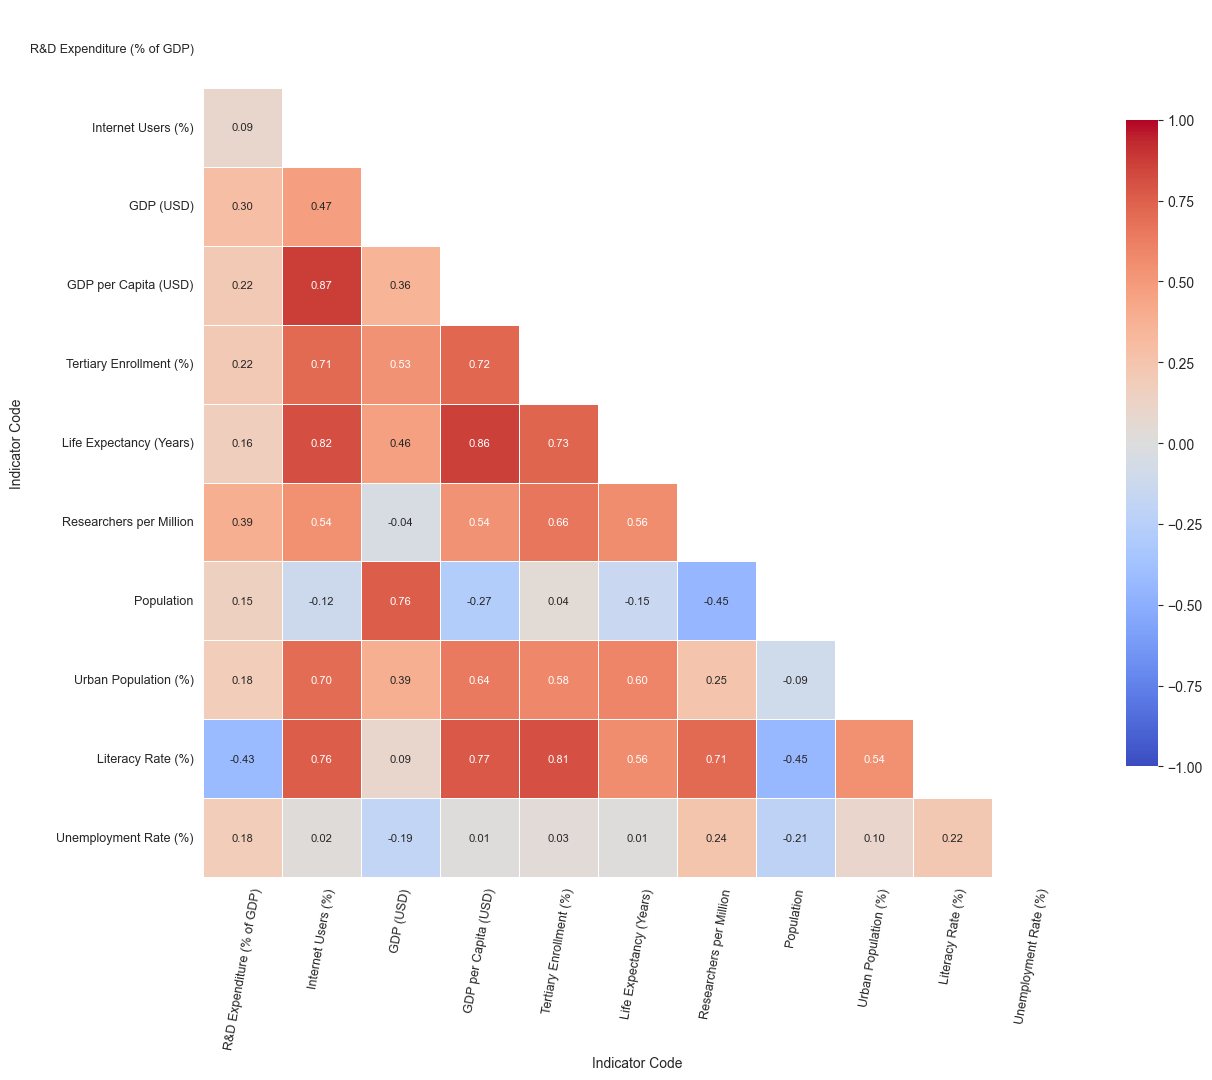

In [239]:
# Define numerical features (exclude country_name and iso3)
numerical_features = [
    'R&D Expenditure (% of GDP)', 'Internet Users (%)', 'GDP (USD)', 'GDP per Capita (USD)',
    'Tertiary Enrollment (%)', 'Life Expectancy (Years)', 'Researchers per Million',
    'Population', 'Urban Population (%)', 'Literacy Rate (%)', 'Unemployment Rate (%)'
]

# create a mask for the upper triangle
mask = np.triu(np.ones((len(numerical_features), len(numerical_features)), dtype=bool))

# Spearman correlation heatmap between numerical features
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(14, 12))
    ax = sns.heatmap(data[numerical_features].corr("spearman"),
        mask=mask, annot=True, fmt=".2f", cmap='coolwarm', square=True, vmin=-1,
        vmax=1, annot_kws={"size": 8}, cbar_kws={"shrink": 0.7}, linewidths=0.5)
    plt.xticks(rotation=80, fontsize=9)
    plt.yticks(fontsize=9)

Now, we are going to start with the preprocessing column by column

R&D Expenditure (% of GDP)

In [240]:
data["R&D Expenditure (% of GDP)"].describe()

count    26.000000
mean      0.432307
std       0.405072
min       0.023760
25%       0.168100
50%       0.260510
75%       0.575037
max       1.701330
Name: R&D Expenditure (% of GDP), dtype: float64

In [241]:
data["R&D Expenditure (% of GDP)"].isnull().sum()

np.int64(182)

Too many nulls to consider working with the column, so we decided to drop it

In [242]:
data = data.drop(columns=["R&D Expenditure (% of GDP)"])

Internet Users (%)

In [243]:
data['Internet Users (%)'].describe()

count    179.000000
mean      72.169654
std       24.525184
min       11.078400
25%       58.255150
50%       81.722100
75%       90.488950
max      100.000000
Name: Internet Users (%), dtype: float64

In [244]:
data['Internet Users (%)'].isnull().sum()

np.int64(29)

Internet Users % has a very high correlation to GDP per Capita so we decided to use that column to impute values on this one

In [245]:
# Create GDP per capita bins (5 equal groups)
data['gdp_pc_bin'] = pd.qcut(data['GDP per Capita (USD)'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

bin_stats = data.groupby('gdp_pc_bin')['Internet Users (%)'].agg(['count', 'median', 'mean'])

#Fill missing values with bin medians
data['Internet Users (%)'] = data.groupby('gdp_pc_bin')['Internet Users (%)'].transform(
    lambda x: x.fillna(x.median())
)

print(f"Missing values after: {data['Internet Users (%)'].isnull().sum()}")

#Remove temporary column
data = data.drop('gdp_pc_bin', axis=1)


            count    median       mean
gdp_pc_bin                            
Very Low       35  33.00000  33.489586
Low            36  69.57645  66.845467
Medium         37  81.36000  80.092070
High           34  87.30700  87.027874
Very High      34  95.84055  95.268476
Missing values after: 15


C:\Users\anton\AppData\Local\Temp\ipykernel_4292\4030359017.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\anton\AppData\Local\Temp\ipykernel_4292\4030359017.py:8: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



There were still some nulls after this, because we still haven't worked on the GDP per capita column, so we used continents for the ones that were left

In [246]:
# For these,we use continent median as fallback
data['Internet Users (%)'] = data.groupby('continent')['Internet Users (%)'].transform(
    lambda x: x.fillna(x.median())
)

print(f"Final missing values: {data['Internet Users (%)'].isnull().sum()}")

Final missing values: 0


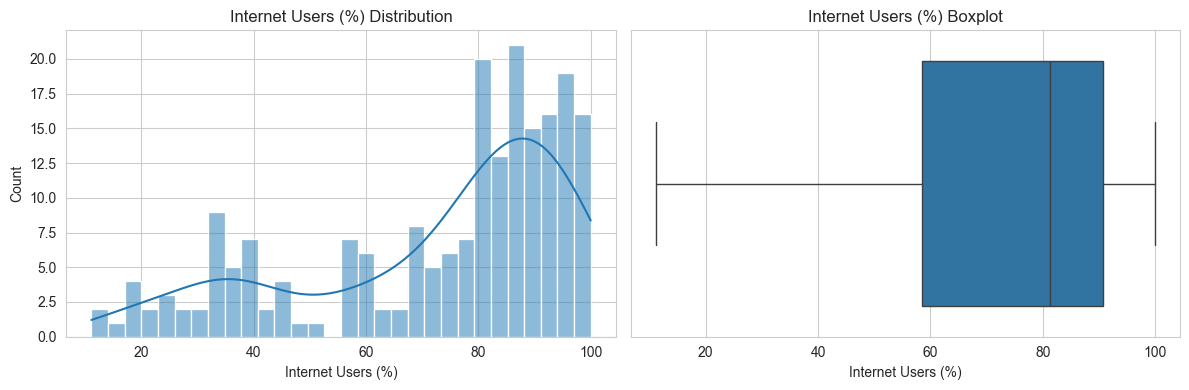

count    208.000000
mean      72.680970
std       24.022326
min       11.078400
25%       58.469775
50%       81.360000
75%       90.700000
max      100.000000
Name: Internet Users (%), dtype: float64
Skewness: -0.97


In [247]:
# Visualize the distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
sns.histplot(data['Internet Users (%)'].dropna(), bins=30, kde=True, ax=ax1)
ax1.set_title('Internet Users (%) Distribution')
ax1.set_xlabel('Internet Users (%)')

# Boxplot
sns.boxplot(x=data['Internet Users (%)'].dropna(), ax=ax2)
ax2.set_title('Internet Users (%) Boxplot')
ax2.set_xlabel('Internet Users (%)')

plt.tight_layout()
plt.show()

# Check basic stats and skewness
print(data['Internet Users (%)'].describe())
print(f"Skewness: {data['Internet Users (%)'].skew():.2f}")

GDP (USD) Column

In [248]:
data["GDP (USD)"].describe()

count    1.930000e+02
mean     5.434795e+11
std      2.459883e+12
min      6.228031e+07
25%      1.065171e+10
50%      3.989829e+10
75%      2.669587e+11
max      2.772071e+13
Name: GDP (USD), dtype: float64

In [249]:
data["GDP (USD)"].isnull().sum()

np.int64(15)

In [250]:
# Create population bins (5 equal groups)
data['population_bin'] = pd.qcut(data['Population'], q=5, labels=['Very Small', 'Small', 'Medium', 'Large', 'Very Large'])


# Fill missing GDP with bin medians
data['GDP (USD)'] = data.groupby('population_bin')['GDP (USD)'].transform(
    lambda x: x.fillna(x.median())
)

print(f"Missing GDP values after: {data['GDP (USD)'].isnull().sum()}")

# Remove temporary column
data = data.drop('population_bin', axis=1)

Missing GDP values before: 15
Missing GDP values after: 0


C:\Users\anton\AppData\Local\Temp\ipykernel_4292\300208287.py:8: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



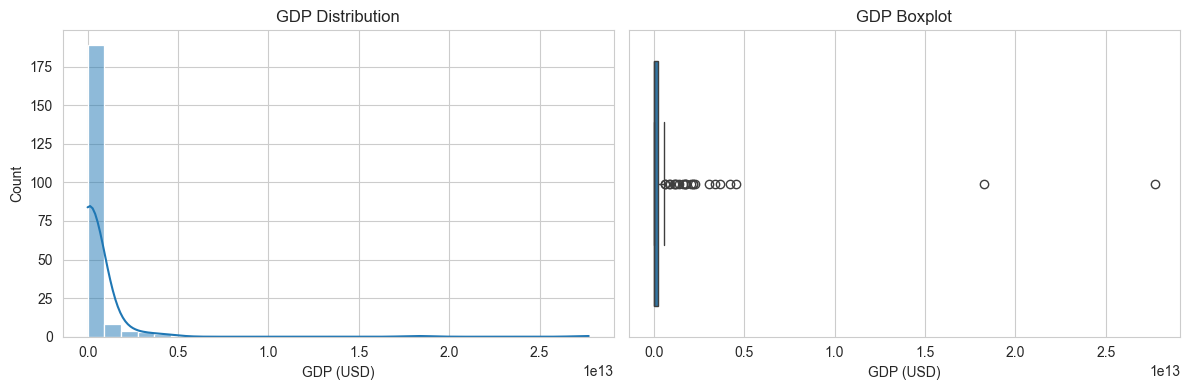

GDP Statistics:
count    2.080000e+02
mean     5.097111e+11
std      2.372507e+12
min      6.228031e+07
25%      8.098460e+09
50%      3.479359e+10
75%      2.568563e+11
max      2.772071e+13
Name: GDP (USD), dtype: float64
Skewness: 9.48


In [251]:
# Visualize the distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
sns.histplot(data['GDP (USD)'].dropna(), bins=30, kde=True, ax=ax1)
ax1.set_title('GDP Distribution')
ax1.set_xlabel('GDP (USD)')

# Boxplot
sns.boxplot(x=data['GDP (USD)'].dropna(), ax=ax2)
ax2.set_title('GDP Boxplot')
ax2.set_xlabel('GDP (USD)')

plt.tight_layout()
plt.show()

# Check basic stats and skewness
print("GDP Statistics:")
print(data['GDP (USD)'].describe())
print(f"Skewness: {data['GDP (USD)'].skew():.2f}")

The data is very skewed to the right and we have outliers, so the log transformation is ideal

In [252]:
# Convert from dollars to billions (divide by 1 billion)
data['GDP (Billions USD)'] = data['GDP (USD)'] / 1_000_000_000

# Remove the original GDP column to avoid confusion
data = data.drop('GDP (USD)', axis=1)

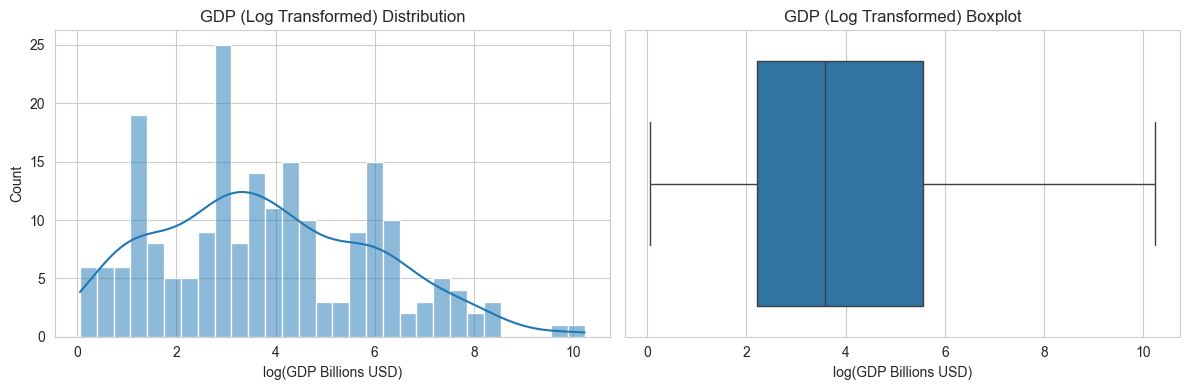

GDP Statistics After Log Transformation:
count    208.000000
mean       3.807509
std        2.153874
min        0.060418
25%        2.207437
50%        3.577694
75%        5.552341
max       10.229971
Name: GDP (Billions USD)_log, dtype: float64
Skewness after log: 0.38


In [253]:
# Log transform the GDP in billions
data['GDP (Billions USD)_log'] = np.log1p(data['GDP (Billions USD)'])

# Check the transformed distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(data['GDP (Billions USD)_log'], bins=30, kde=True, ax=ax1)
ax1.set_title('GDP (Log Transformed) Distribution')
ax1.set_xlabel('log(GDP Billions USD)')

sns.boxplot(x=data['GDP (Billions USD)_log'], ax=ax2)
ax2.set_title('GDP (Log Transformed) Boxplot')
ax2.set_xlabel('log(GDP Billions USD)')

plt.tight_layout()
plt.show()

print("GDP Statistics After Log Transformation:")
print(data['GDP (Billions USD)_log'].describe())
print(f"Skewness after log: {data['GDP (Billions USD)_log'].skew():.2f}")

GDP per Capita (USD) Column

In [254]:
data['GDP per Capita (USD)'].describe()

count       193.000000
mean      20467.235103
std       32236.226073
min         192.074305
25%        2554.673049
50%        7826.353765
75%       23804.024991
max      256580.515123
Name: GDP per Capita (USD), dtype: float64

In [255]:
data['GDP per Capita (USD)'].isnull().sum()

np.int64(15)

Check which countries are missing and calculate them manually

In [256]:
# Find countries missing GDP per capita
missing_gdp = data['GDP per Capita (USD)'].isnull()

# Calculate GDP per capita = GDP / Population
data.loc[missing_gdp, 'GDP per Capita (USD)'] = (
    data.loc[missing_gdp, 'GDP (Billions USD)'] * 1_000_000_000 /  # Convert back to dollars
    data.loc[missing_gdp, 'Population']
)

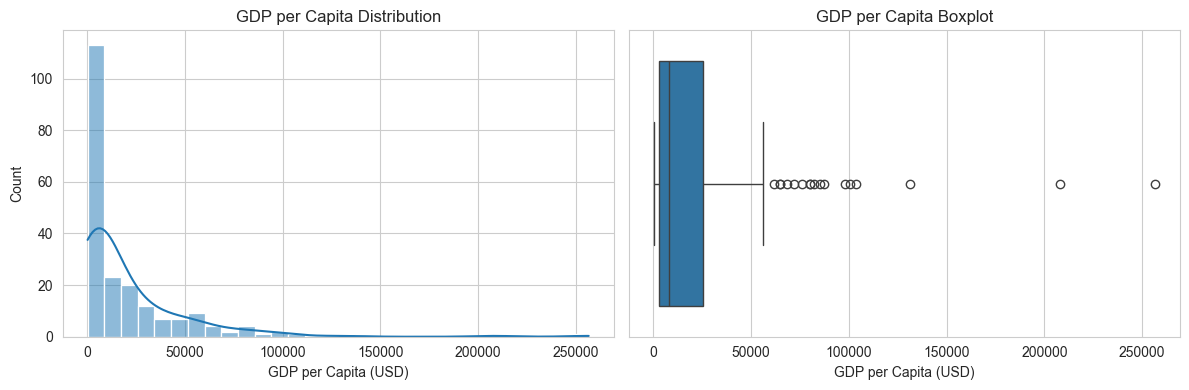

GDP per Capita Statistics:
count       208.000000
mean      20806.572804
std       31782.238038
min         192.074305
25%        2811.587825
50%        7868.384497
75%       25529.361020
max      256580.515123
Name: GDP per Capita (USD), dtype: float64
Skewness: 3.70


In [257]:
# Visualize the distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
sns.histplot(data['GDP per Capita (USD)'].dropna(), bins=30, kde=True, ax=ax1)
ax1.set_title('GDP per Capita Distribution')
ax1.set_xlabel('GDP per Capita (USD)')

# Boxplot
sns.boxplot(x=data['GDP per Capita (USD)'].dropna(), ax=ax2)
ax2.set_title('GDP per Capita Boxplot')
ax2.set_xlabel('GDP per Capita (USD)')

plt.tight_layout()
plt.show()

# Check basic stats and skewness
print("GDP per Capita Statistics:")
print(data['GDP per Capita (USD)'].describe())
print(f"Skewness: {data['GDP per Capita (USD)'].skew():.2f}")

As in the GDP column, it is very right skewed and there are outliers, so we use the log transformation

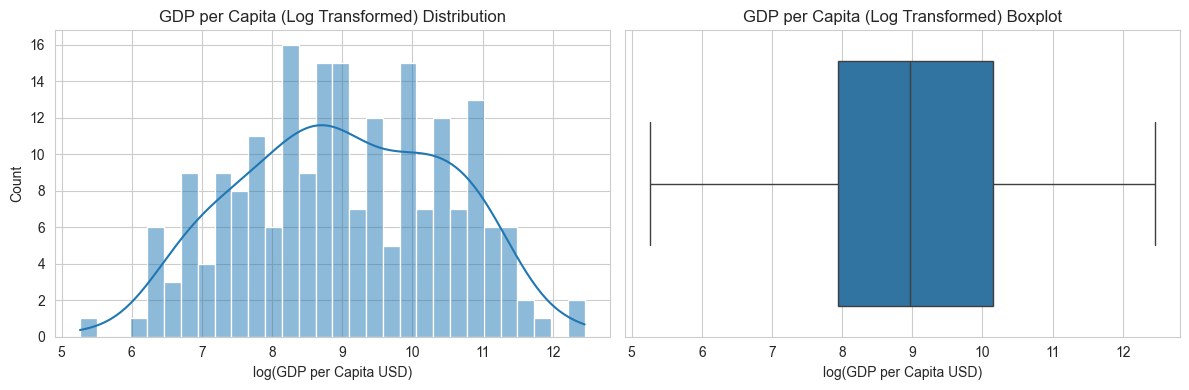

GDP per Capita Statistics After Log Transformation:
count    208.000000
mean       9.022859
std        1.450238
min        5.263075
25%        7.940970
50%        8.970732
75%       10.146769
max       12.455202
Name: GDP per Capita (USD)_log, dtype: float64
Skewness after log: -0.05


In [258]:
data['GDP per Capita (USD)_log'] = np.log1p(data['GDP per Capita (USD)'])

# Check the transformed distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(data['GDP per Capita (USD)_log'].dropna(), bins=30, kde=True, ax=ax1)
ax1.set_title('GDP per Capita (Log Transformed) Distribution')
ax1.set_xlabel('log(GDP per Capita USD)')

sns.boxplot(x=data['GDP per Capita (USD)_log'].dropna(), ax=ax2)
ax2.set_title('GDP per Capita (Log Transformed) Boxplot')
ax2.set_xlabel('log(GDP per Capita USD)')

plt.tight_layout()
plt.show()

print("GDP per Capita Statistics After Log Transformation:")
print(data['GDP per Capita (USD)_log'].describe())
print(f"Skewness after log: {data['GDP per Capita (USD)_log'].skew():.2f}")

Literacy Rate (%)

In [259]:
data["Literacy Rate (%)"].describe()

count    30.000000
mean     89.416590
std      13.424540
min      41.442034
25%      87.227497
50%      94.455242
75%      97.407499
max      99.839996
Name: Literacy Rate (%), dtype: float64

In [260]:
data["Literacy Rate (%)"].isnull().sum()

np.int64(178)

Too many nulls to work with the column

In [261]:
data = data.drop(columns=["Literacy Rate (%)"])

Tertiary Enrollment (%)

In [262]:
data["Tertiary Enrollment (%)"].describe()

count    121.000000
mean      52.437498
std       30.367261
min        4.937851
25%       25.253708
50%       53.694964
75%       76.381142
max      165.113419
Name: Tertiary Enrollment (%), dtype: float64

In [263]:
data["Tertiary Enrollment (%)"].isnull().sum()

np.int64(87)

Before imputing these values, we check if there is a pattern in the missing data

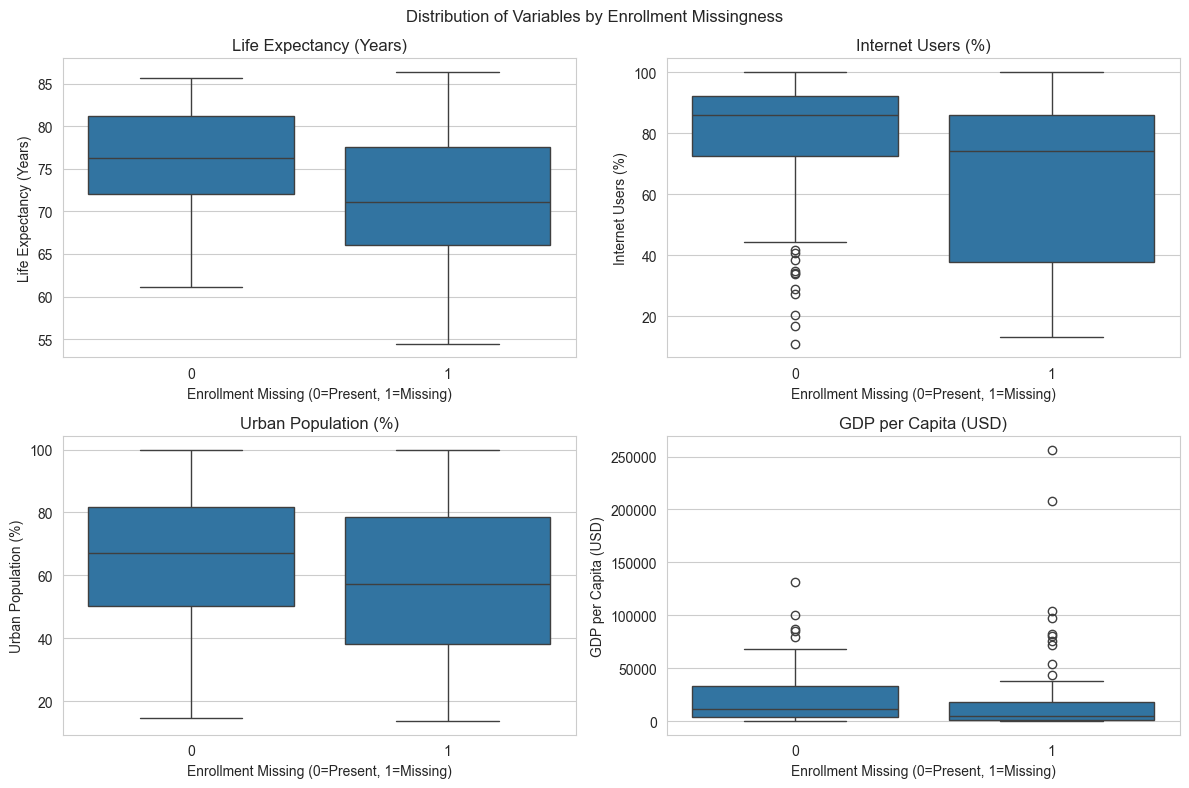

In [264]:
# Calculate boxplots and other visualizations to check MAR assumption
predictors = ['Life Expectancy (Years)', 'Internet Users (%)', 
             'Urban Population (%)', 'GDP per Capita (USD)']

enrollment_missing = data['Tertiary Enrollment (%)'].isnull().astype(int)

# Create boxplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Distribution of Variables by Enrollment Missingness')

for idx, col in enumerate(predictors):
    ax = axes[idx//2, idx%2]
    sns.boxplot(x=enrollment_missing, y=data[col], ax=ax)
    ax.set_xlabel('Enrollment Missing (0=Present, 1=Missing)')
    ax.set_title(col)

plt.tight_layout()
plt.show()

DATA MISSING AT RANDOM

Fill the nulls using MICE (method showed in the class)

In [265]:
# Create dataset with simple names because was I having issues with special characters
mice_data = data[['Life Expectancy (Years)', 'Internet Users (%)', 
                  'Urban Population (%)', 'GDP per Capita (USD)', 
                  'Tertiary Enrollment (%)']].copy()

mice_data.columns = ['life', 'internet', 'urban', 'gdp', 'enroll']

# Store the original missingness pattern before imputation
original_missing_mask = mice_data['enroll'].isnull() 

imp = MICEData(mice_data)

# Run iterations
for j in range(10):
    imp.update_all()

# Use the final imputed dataset
data['Tertiary Enrollment (%)'] = imp.data['enroll']

print(f"Final missing: {data['Tertiary Enrollment (%)'].isnull().sum()}")

Missing before imputation: 87
Final missing: 0


In [266]:
# Compare countries with missing vs complete data
missing_countries = data[original_missing_mask].index
complete_countries = data[~original_missing_mask].index

print("Countries WITH enrollment data (mean values):")
print(data.loc[complete_countries, ['GDP per Capita (USD)', 'Life Expectancy (Years)', 'Internet Users (%)','Urban Population (%)']].mean())

print("\nCountries MISSING enrollment data (mean values):")
print(data.loc[missing_countries, ['GDP per Capita (USD)', 'Life Expectancy (Years)', 'Internet Users (%)','Urban Population (%)']].mean())

Countries WITH enrollment data (mean values):
Indicator Code
GDP per Capita (USD)       21978.062528
Life Expectancy (Years)       75.662072
Internet Users (%)            78.917230
Urban Population (%)          64.523678
dtype: float64

Countries MISSING enrollment data (mean values):
Indicator Code
GDP per Capita (USD)       19177.259511
Life Expectancy (Years)       71.035897
Internet Users (%)            64.007551
Urban Population (%)          57.491435
dtype: float64


We analyzed whether missing enrollment data was random or systematic.
Results show countries with missing data have:
- Lower GDP ($19,177 vs $21,978)
- Lower life expectancy (71.0 vs 75.7 years)  
- Fewer internet users (64.0% vs 78.9%)
- Lower urban population (57.5% vs 64.5%)

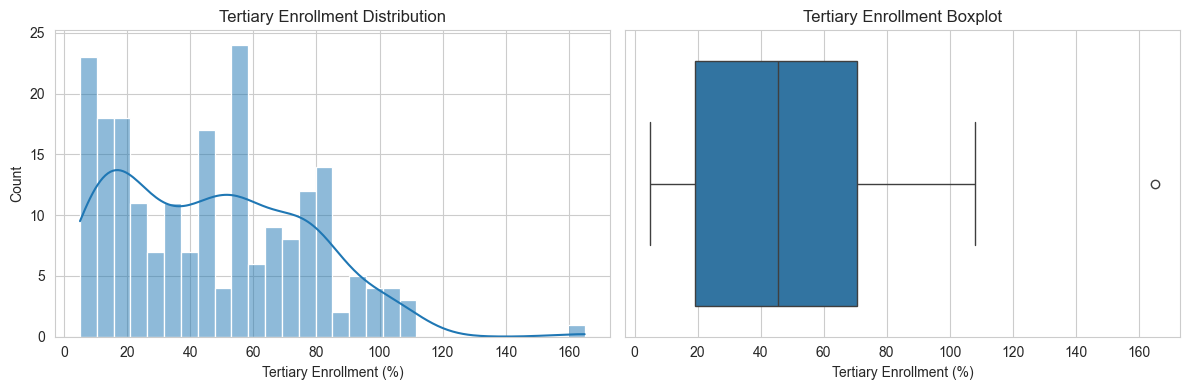

count    208.000000
mean      46.550891
std       29.774746
min        4.937851
25%       19.035761
50%       45.471771
75%       70.453644
max      165.113419
Name: Tertiary Enrollment (%), dtype: float64
Skewness: 0.52


In [267]:
# Visualize the distribution of Tertiary Enrollment (%)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
sns.histplot(data['Tertiary Enrollment (%)'].dropna(), bins=30, kde=True, ax=ax1)
ax1.set_title('Tertiary Enrollment Distribution')
ax1.set_xlabel('Tertiary Enrollment (%)')

# Boxplot
sns.boxplot(x=data['Tertiary Enrollment (%)'].dropna(), ax=ax2)
ax2.set_title('Tertiary Enrollment Boxplot')
ax2.set_xlabel('Tertiary Enrollment (%)')

plt.tight_layout()
plt.show()

# Check basic stats and skewness
print(data['Tertiary Enrollment (%)'].describe())
print(f"Skewness: {data['Tertiary Enrollment (%)'].skew():.2f}")

Unemployment Rate (%)

In [268]:
data["Unemployment Rate (%)"].describe()

count    178.000000
mean       6.791596
std        5.327259
min        0.130000
25%        3.132750
50%        5.183500
75%        8.949500
max       35.086000
Name: Unemployment Rate (%), dtype: float64

In [269]:
data['Unemployment Rate (%)'].isnull().sum()

np.int64(30)

There were not that many nulls and this column didnt have any strong spearman correlation with others, so we opted for a median imputation by continent


In [270]:
# Fill missing values with continental median
data['Unemployment Rate (%)'] = data.groupby('continent')['Unemployment Rate (%)'].transform(
    lambda x: x.fillna(x.median())
)

print(f"Missing after continental imputation: {data['Unemployment Rate (%)'].isnull().sum()}")

Missing after continental imputation: 0


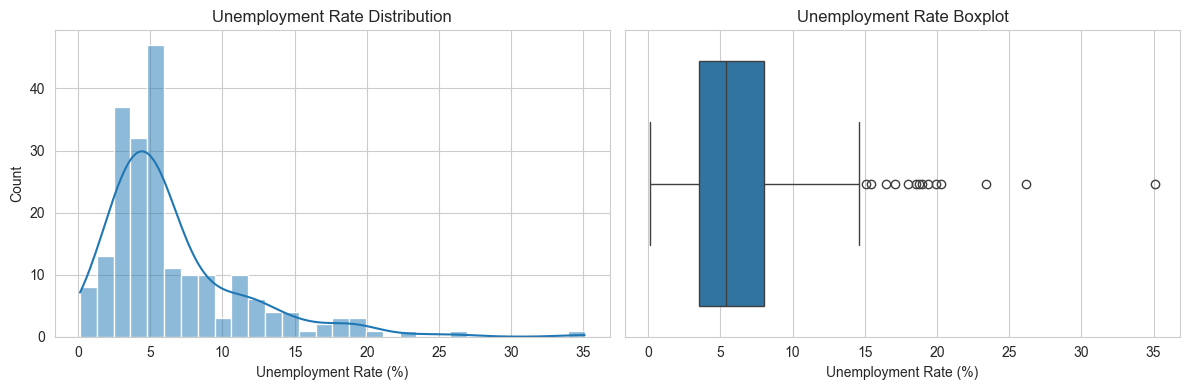

count    208.000000
mean       6.561815
std        4.965534
min        0.130000
25%        3.516000
50%        5.396000
75%        8.027000
max       35.086000
Name: Unemployment Rate (%), dtype: float64
Skewness: 2.11


In [271]:
# Visualize the distribution of Unemployment Rate (%)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
sns.histplot(data['Unemployment Rate (%)'].dropna(), bins=30, kde=True, ax=ax1)
ax1.set_title('Unemployment Rate Distribution')
ax1.set_xlabel('Unemployment Rate (%)')

# Boxplot
sns.boxplot(x=data['Unemployment Rate (%)'].dropna(), ax=ax2)
ax2.set_title('Unemployment Rate Boxplot')
ax2.set_xlabel('Unemployment Rate (%)')

plt.tight_layout()
plt.show()

# Check basic stats and skewness
print(data['Unemployment Rate (%)'].describe())
print(f"Skewness: {data['Unemployment Rate (%)'].skew():.2f}")

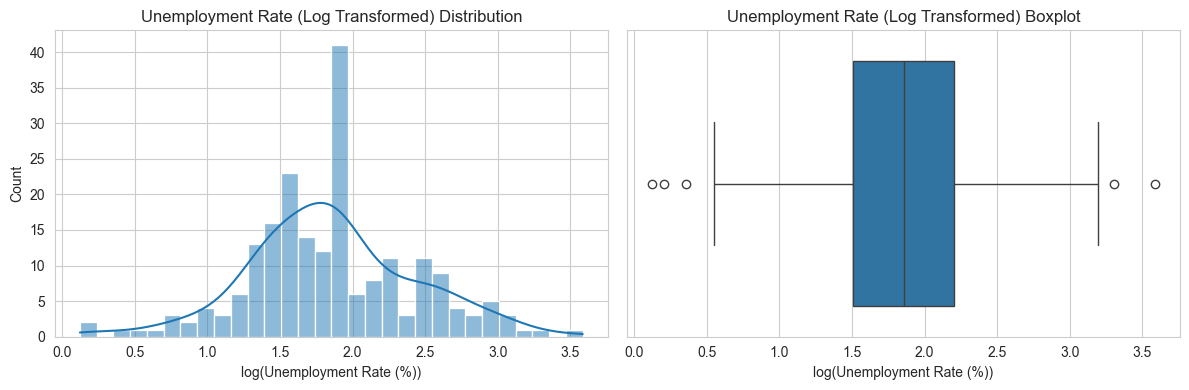

In [272]:
# Log transform
data['Unemployment Rate (%)_log'] = np.log1p(data['Unemployment Rate (%)'])

# Check the transformed distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(data['Unemployment Rate (%)_log'].dropna(), bins=30, kde=True, ax=ax1)
ax1.set_title('Unemployment Rate (Log Transformed) Distribution')
ax1.set_xlabel('log(Unemployment Rate (%))')
sns.boxplot(x=data['Unemployment Rate (%)_log'].dropna(), ax=ax2)
ax2.set_title('Unemployment Rate (Log Transformed) Boxplot')
ax2.set_xlabel('log(Unemployment Rate (%))')
plt.tight_layout()
plt.show()


Life Expectancy (Years)

In [273]:
data["Life Expectancy (Years)"].describe()

count    208.000000
mean      73.727085
std        7.067774
min       54.462000
25%       68.447250
50%       74.462500
75%       78.740500
max       86.372000
Name: Life Expectancy (Years), dtype: float64

In [274]:
data['Unemployment Rate (%)'].isnull().sum()

np.int64(0)

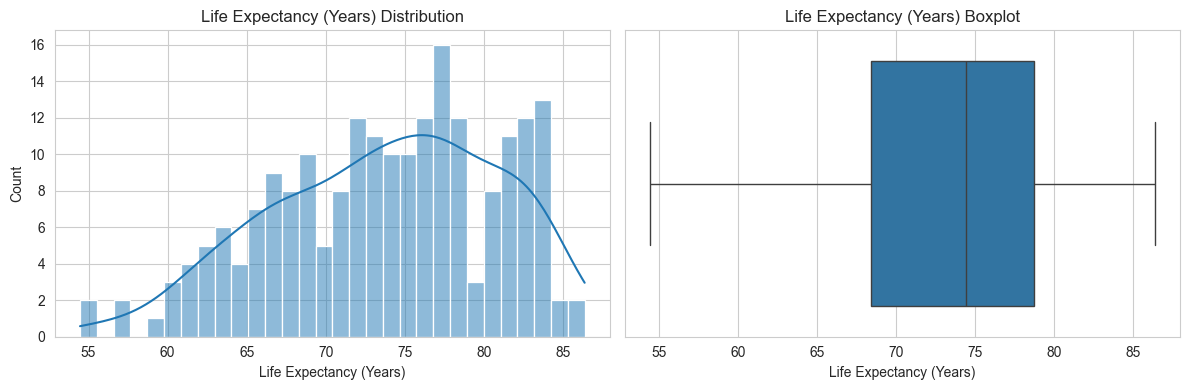

count    208.000000
mean      73.727085
std        7.067774
min       54.462000
25%       68.447250
50%       74.462500
75%       78.740500
max       86.372000
Name: Life Expectancy (Years), dtype: float64
Skewness: -0.38


In [275]:
# Visualize the distribution of Life Expectancy (Years)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
sns.histplot(data['Life Expectancy (Years)'].dropna(), bins=30, kde=True, ax=ax1)
ax1.set_title('Life Expectancy (Years) Distribution')
ax1.set_xlabel('Life Expectancy (Years)')

# Boxplot
sns.boxplot(x=data['Life Expectancy (Years)'].dropna(), ax=ax2)
ax2.set_title('Life Expectancy (Years) Boxplot')
ax2.set_xlabel('Life Expectancy (Years)')

plt.tight_layout()
plt.show()

# Check basic stats and skewness
print(data['Life Expectancy (Years)'].describe())
print(f"Skewness: {data['Life Expectancy (Years)'].skew():.2f}")

In [276]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Country                    208 non-null    object 
 1   ISO3                       208 non-null    object 
 2   Internet Users (%)         208 non-null    float64
 3   GDP per Capita (USD)       208 non-null    float64
 4   Tertiary Enrollment (%)    208 non-null    float64
 5   Unemployment Rate (%)      208 non-null    float64
 6   Life Expectancy (Years)    208 non-null    float64
 7   Researchers per Million    28 non-null     float64
 8   Population                 208 non-null    float64
 9   Urban Population (%)       206 non-null    float64
 10  continent                  208 non-null    object 
 11  GDP (Billions USD)         208 non-null    float64
 12  GDP (Billions USD)_log     208 non-null    float64
 13  GDP per Capita (USD)_log   208 non-null    float64

Researchers per Million

In [277]:
data["Researchers per Million"].isnull().sum()

np.int64(180)

In [278]:
data = data.drop(columns=["Researchers per Million"])

Population

In [279]:
data["Population"].describe()

count    2.080000e+02
mean     3.831180e+07
std      1.450446e+08
min      9.816000e+03
25%      1.211116e+06
50%      7.202704e+06
75%      2.706480e+07
max      1.438070e+09
Name: Population, dtype: float64

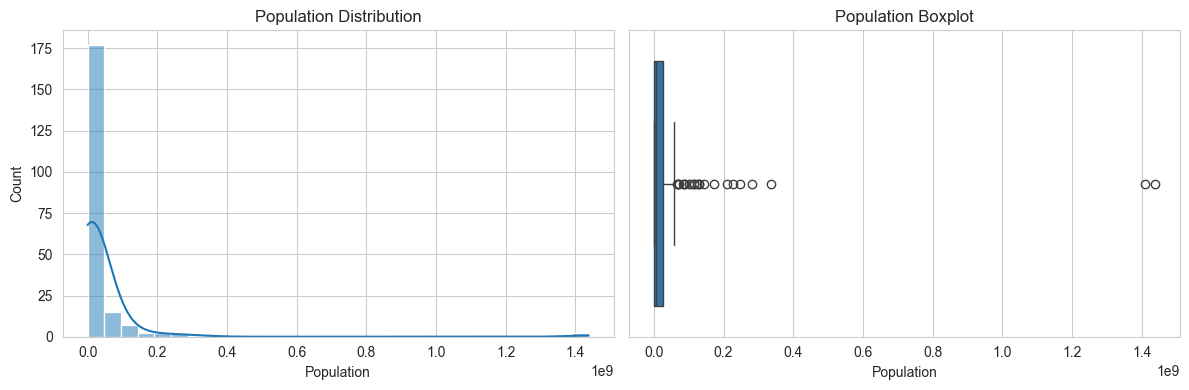

count    2.080000e+02
mean     3.831180e+07
std      1.450446e+08
min      9.816000e+03
25%      1.211116e+06
50%      7.202704e+06
75%      2.706480e+07
max      1.438070e+09
Name: Population, dtype: float64
Skewness: 8.62


In [280]:
# Visualize the distribution of Population
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
sns.histplot(data['Population'].dropna(), bins=30, kde=True, ax=ax1)
ax1.set_title('Population Distribution')
ax1.set_xlabel('Population')

# Boxplot
sns.boxplot(x=data['Population'].dropna(), ax=ax2)
ax2.set_title('Population Boxplot')
ax2.set_xlabel('Population')

plt.tight_layout()
plt.show()

# Check basic stats and skewness
print(data['Population'].describe())
print(f"Skewness: {data['Population'].skew():.2f}")

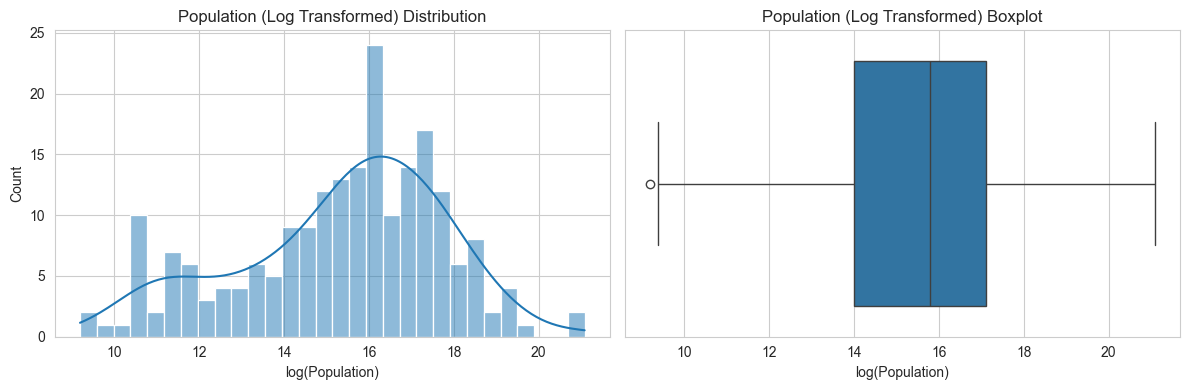

In [281]:
# Log transform
data['Population_log'] = np.log1p(data['Population'])
# Check the transformed distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(data['Population_log'].dropna(), bins=30, kde=True, ax=ax1)
ax1.set_title('Population (Log Transformed) Distribution')
ax1.set_xlabel('log(Population)')
sns.boxplot(x=data['Population_log'].dropna(), ax=ax2)
ax2.set_title('Population (Log Transformed) Boxplot')
ax2.set_xlabel('log(Population)')
plt.tight_layout()
plt.show()

Urban Population (%)

In [282]:
data["Urban Population (%)"].describe()

count    206.000000
mean      61.622024
std       23.371518
min       13.723000
25%       43.593250
50%       63.176000
75%       81.528000
max      100.000000
Name: Urban Population (%), dtype: float64

In [283]:
data["Urban Population (%)"].isnull().sum()

np.int64(2)

In [284]:
# Identify the 2 countries with missing urban population data
missing_urban = data[data['Urban Population (%)'].isnull()]
print(missing_urban[['Country', 'Urban Population (%)']])

Indicator Code                   Country  Urban Population (%)
100                               Kosovo                   NaN
174             St. Martin (French part)                   NaN


In [285]:
# Define regional groups
regional_groups = {
    'Balkan': ['Albania', 'Serbia', 'North Macedonia', 'Montenegro', 
               'Bosnia and Herzegovina', 'Croatia', 'Slovenia'],
    'Caribbean_Islands': ['Bahamas', 'Barbados', 'Trinidad and Tobago', 
                         'Jamaica', 'Dominican Republic', 'Haiti', 'Cuba'],
}

# For Kosovo (Balkan region)
balkan_countries = [c for c in regional_groups['Balkan'] if c in data['Country'].values]
balkan_urban_mean = data[data['Country'].isin(balkan_countries)]['Urban Population (%)'].mean()

# For St. Martin (Caribbean islands)  
caribbean_countries = [c for c in regional_groups['Caribbean_Islands'] if c in data['Country'].values]
caribbean_urban_mean = data[data['Country'].isin(caribbean_countries)]['Urban Population (%)'].mean()

print(f"Balkan region urban average: {balkan_urban_mean:.1f}%")
print(f"Caribbean islands urban average: {caribbean_urban_mean:.1f}%")

# Apply the imputation
data.loc[data['Country'] == 'Kosovo', 'Urban Population (%)'] = balkan_urban_mean
data.loc[data['Country'] == 'St. Martin (French part)', 'Urban Population (%)'] = caribbean_urban_mean

Balkan region urban average: 59.2%
Caribbean islands urban average: 60.6%


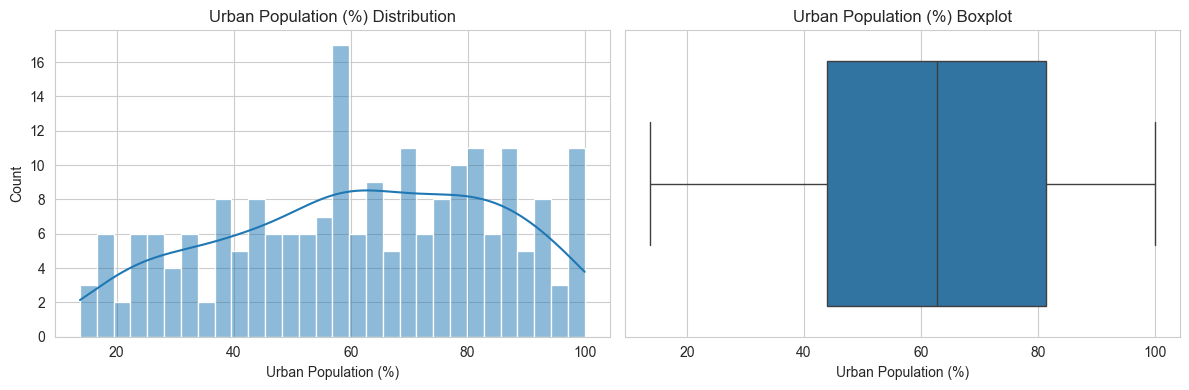

count    208.000000
mean      61.605838
std       23.259025
min       13.723000
25%       44.033750
50%       62.718500
75%       81.480000
max      100.000000
Name: Urban Population (%), dtype: float64
Skewness: -0.22


In [286]:
# Visualize the distribution of Urban Population (%)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
sns.histplot(data['Urban Population (%)'].dropna(), bins=30, kde=True, ax=ax1)
ax1.set_title('Urban Population (%) Distribution')
ax1.set_xlabel('Urban Population (%)')

# Boxplot
sns.boxplot(x=data['Urban Population (%)'].dropna(), ax=ax2)
ax2.set_title('Urban Population (%) Boxplot')
ax2.set_xlabel('Urban Population (%)')

plt.tight_layout()
plt.show()

# Check basic stats and skewness
print(data['Urban Population (%)'].describe())
print(f"Skewness: {data['Urban Population (%)'].skew():.2f}")

In [287]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Country                    208 non-null    object 
 1   ISO3                       208 non-null    object 
 2   Internet Users (%)         208 non-null    float64
 3   GDP per Capita (USD)       208 non-null    float64
 4   Tertiary Enrollment (%)    208 non-null    float64
 5   Unemployment Rate (%)      208 non-null    float64
 6   Life Expectancy (Years)    208 non-null    float64
 7   Population                 208 non-null    float64
 8   Urban Population (%)       208 non-null    float64
 9   continent                  208 non-null    object 
 10  GDP (Billions USD)         208 non-null    float64
 11  GDP (Billions USD)_log     208 non-null    float64
 12  GDP per Capita (USD)_log   208 non-null    float64
 13  Unemployment Rate (%)_log  208 non-null    float64

## Now let's pass to the next section of the analysis, the comparison with the research paper. (OpenAlex API)

In [288]:
data_api = data.copy()

To search papers for every country we need the ISO2, so let's make a transformation using pycountry (ISO3-->ISO2)

In [289]:
def iso3_to_iso2(iso3):
    try:
        return pycountry.countries.get(alpha_3=iso3).alpha_2
    except:
        return None  

data_api["ISO2"] = data_api["ISO3"].apply(iso3_to_iso2)

print(data_api[["Country", "ISO3", "ISO2"]])

Indicator Code                Country ISO3 ISO2
0                         Afghanistan  AFG   AF
1                             Albania  ALB   AL
2                             Algeria  DZA   DZ
3                      American Samoa  ASM   AS
4                             Andorra  AND   AD
..                                ...  ...  ...
203             Virgin Islands (U.S.)  VIR   VI
204                West Bank and Gaza  PSE   PS
205                       Yemen, Rep.  YEM   YE
206                            Zambia  ZMB   ZM
207                          Zimbabwe  ZWE   ZW

[208 rows x 3 columns]


Now we search the number of papers published in every country in 2023

In [290]:
BASE_URL = "https://api.openalex.org/works"

countries = list(data_api.ISO2) #list of country ISO2 codes
CACHE_FILENAME = "paper_counts.json"

paper = [] 

# Check if cache file exists 
# We made this part to avoid overloading the API multiple times during development
if os.path.exists(CACHE_FILENAME):
    print(f"Loading data from cache: {CACHE_FILENAME}")
    # Load data from the file directly into our 'paper' variable
    with open(CACHE_FILENAME, 'r') as f:
        paper = json.load(f) 

# If no cache
else:
    print("Cache not found. Running original API loop...")
    
    for c in countries:
        params = {
            "filter": f"publication_year:2023,authorships.institutions.country_code:{c}"
        }
        r = requests.get(BASE_URL, params=params)
        
        if r.status_code == 200:
            count = r.json()["meta"]["count"]
            paper.append({"country": c, "paper_count": count})
            print(f"{c}: {count}")
        else:
            print(f"Errore per {c}")
        time.sleep(1) #not to overload the API

    # After the loop, save the 'paper' list to the file
    print(f"\nSaving data to {CACHE_FILENAME} for next time...")
    with open(CACHE_FILENAME, 'w') as f:
        json.dump(paper, f, indent=4) 
    print("Data saved.")

print("\n--- Final Data Ready for Use ---")
print(paper)

Loading data from cache: paper_counts.json

--- Final Data Ready for Use ---
[{'country': 'AF', 'paper_count': 1306}, {'country': 'AL', 'paper_count': 1942}, {'country': 'DZ', 'paper_count': 13643}, {'country': 'AS', 'paper_count': 22}, {'country': 'AD', 'paper_count': 56}, {'country': 'AO', 'paper_count': 540}, {'country': 'AG', 'paper_count': 846}, {'country': 'AR', 'paper_count': 27677}, {'country': 'AM', 'paper_count': 3085}, {'country': 'AW', 'paper_count': 62}, {'country': 'AU', 'paper_count': 149187}, {'country': 'AT', 'paper_count': 44160}, {'country': 'AZ', 'paper_count': 4575}, {'country': 'BS', 'paper_count': 161}, {'country': 'BH', 'paper_count': 2273}, {'country': 'BD', 'paper_count': 24876}, {'country': 'BB', 'paper_count': 376}, {'country': 'BY', 'paper_count': 4576}, {'country': 'BE', 'paper_count': 56468}, {'country': 'BZ', 'paper_count': 71}, {'country': 'BJ', 'paper_count': 2024}, {'country': 'BT', 'paper_count': 351}, {'country': 'BO', 'paper_count': 2069}, {'countr

We can include this column to the dataset

In [291]:
data_api_papers = data_api.merge(pd.DataFrame(paper), left_on="ISO2", right_on="country", how="left").drop(columns=["country"])

Let's see if this worked correctly and if there is some NA values

In [292]:
data_api_papers[data_api_papers['ISO2'].isnull()==True]

,Country,ISO3,Internet Users (%),GDP per Capita (USD),Tertiary Enrollment (%),Unemployment Rate (%),Life Expectancy (Years),Population,Urban Population (%),continent,GDP (Billions USD),GDP (Billions USD)_log,GDP per Capita (USD)_log,Unemployment Rate (%)_log,Population_log,ISO2,paper_count
100,Kosovo,XKX,81.36,6221.203652,53.694964,5.396,78.033,1682668.0,59.232714,Europe,10.46822,2.43958,8.735879,1.855673,14.335892,None,0


Only one country (Kosovo) was not found by our algorithm 

In [293]:
data_api_papers

,Country,ISO3,Internet Users (%),GDP per Capita (USD),Tertiary Enrollment (%),Unemployment Rate (%),Life Expectancy (Years),Population,Urban Population (%),continent,GDP (Billions USD),GDP (Billions USD)_log,GDP per Capita (USD)_log,Unemployment Rate (%)_log,Population_log,ISO2,paper_count
0,Afghanistan,AFG,17.7089,413.757895,10.049358,13.9910,66.035000,41454761.0,26.933,Asia,17.152235,2.898794,6.027695,2.707450,17.540113,AF,1306
1,Albania,ALB,83.1356,8575.171346,64.729352,10.1080,79.602000,2745972.0,64.603,Europe,23.547180,3.200597,9.056743,2.407666,14.825646,AL,1942
2,Algeria,DZA,76.9081,5364.027950,55.532019,11.7010,76.261000,46164219.0,75.268,Africa,247.626161,5.515950,8.587657,2.541681,17.647716,DZ,13643
3,American Samoa,ASM,74.3146,44119.073040,26.649306,4.0255,72.852000,47521.0,87.235,Oceania,2.096582,1.130299,10.694670,1.614525,10.768948,AS,22
4,Andorra,AND,95.4456,46812.448449,62.410694,5.3960,84.041000,80856.0,87.774,Europe,3.785067,1.565500,10.753926,1.855673,11.300437,AD,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,Virgin Islands (U.S.),VIR,81.1832,19983.248377,70.453644,12.3200,80.519512,104917.0,96.227,North America,2.096582,1.130299,9.902700,2.589267,11.560934,VI,133
204,West Bank and Gaza,PSE,86.6377,3455.028529,44.490462,4.1355,65.170000,5165775.0,77.582,Asia,17.847900,2.936402,8.147875,1.636177,15.457566,PS,2962
205,"Yemen, Rep.",YEM,85.9607,11099.939357,19.350962,17.0910,69.295000,39390799.0,39.831,Asia,437.235480,6.082756,9.314785,2.895415,17.489043,YE,3708
206,Zambia,ZMB,33.0000,1330.727806,14.610664,5.9050,66.349000,20723965.0,46.335,Africa,27.577956,3.352636,7.194232,1.932246,16.846801,ZM,2476


Let's see best and worst countries in terms of publications

In [294]:
data_api_papers_sorted = data_api_papers.sort_values(by='paper_count', ascending=False).reset_index(drop=True)

print(data_api_papers_sorted[['Country', 'paper_count', 'Population']].head(20))
data_api_papers_sorted

               Country  paper_count    Population
0        United States      1159821  3.368062e+08
1                China      1096429  1.410710e+09
2                India       379134  1.438070e+09
3            Indonesia       358646  2.811901e+08
4       United Kingdom       330715  6.849200e+07
5              Germany       296526  8.390192e+07
6               France       231749  6.828749e+07
7               Brazil       213361  2.111407e+08
8                Italy       195124  5.899348e+07
9                Japan       184029  1.245166e+08
10               Spain       174731  4.834791e+07
11              Canada       173890  4.008348e+07
12  Russian Federation       161984  1.438261e+08
13           Australia       149187  2.665278e+07
14             Turkiye       138266  8.532596e+07
15         Korea, Rep.       123061  5.171262e+07
16         Netherlands        99610  1.787712e+07
17              Poland        84045  3.668735e+07
18  Iran, Islamic Rep.        81816  9.060871e+07


,Country,ISO3,Internet Users (%),GDP per Capita (USD),Tertiary Enrollment (%),Unemployment Rate (%),Life Expectancy (Years),Population,Urban Population (%),continent,GDP (Billions USD),GDP (Billions USD)_log,GDP per Capita (USD)_log,Unemployment Rate (%)_log,Population_log,ISO2,paper_count
0,United States,USA,93.14440,82304.620427,67.617928,3.6380,78.385366,3.368062e+08,83.298000,North America,27720.709000,10.229971,11.318195,1.534283,19.635018,US,1159821
1,China,CHN,90.60000,12951.178240,74.593301,4.6700,77.953000,1.410710e+09,64.570000,Asia,18270.356655,9.813090,9.469019,1.735189,21.067359,CN,1096429
2,India,IND,69.57645,2530.120313,34.009170,4.1720,72.003000,1.438070e+09,36.364000,Asia,3638.489096,8.199599,7.836417,1.643259,21.086567,IN,379134
3,Indonesia,IDN,69.20840,4876.307745,44.881303,3.3080,71.146000,2.811901e+08,58.572000,Asia,1371.169302,7.224148,8.492349,1.460474,19.454541,ID,358646
4,United Kingdom,GBR,96.29880,49200.810153,80.498772,3.9840,81.238098,6.849200e+07,84.642000,Europe,3369.861889,8.122924,10.803686,1.606233,18.042228,GB,330715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,Comoros,COM,35.66780,1682.202851,8.886243,3.7760,66.777000,8.503870e+05,30.132000,Africa,1.430523,0.888107,7.428454,1.563603,13.653448,KM,0
204,Nauru,NRU,87.30700,12754.186757,34.009170,4.0255,62.109000,1.187500e+04,100.000000,Oceania,0.151456,0.141027,9.453693,1.614525,9.382275,NR,0
205,Marshall Islands,MHL,65.71770,6678.342391,17.436236,4.0255,66.945000,3.882700e+04,78.868000,Oceania,0.259300,0.230556,8.806775,1.614525,10.566897,MH,0
206,Kosovo,XKX,81.36000,6221.203652,53.694964,5.3960,78.033000,1.682668e+06,59.232714,Europe,10.468220,2.439580,8.735879,1.855673,14.335892,None,0


Is there correlation between papers and other variables?

C:\Users\anton\AppData\Local\Temp\ipykernel_4292\1945887194.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




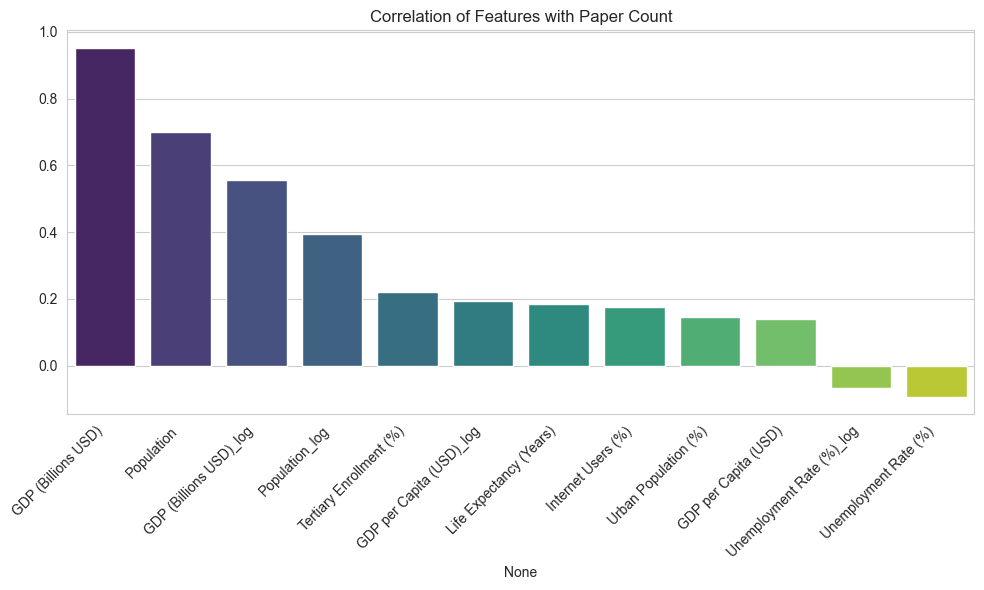


Correlation Matrix:
paper_count                  1.000000
GDP (Billions USD)           0.951805
Population                   0.698988
GDP (Billions USD)_log       0.555734
Population_log               0.394407
Tertiary Enrollment (%)      0.221365
GDP per Capita (USD)_log     0.193811
Life Expectancy (Years)      0.184190
Internet Users (%)           0.174506
Urban Population (%)         0.145754
GDP per Capita (USD)         0.139304
Unemployment Rate (%)_log   -0.068482
Unemployment Rate (%)       -0.094178
Name: paper_count, dtype: float64


In [295]:
# Correlation analysis
correlation_matrix = data_api_papers_sorted.select_dtypes(include=['float', 'int']).corr()['paper_count'].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_matrix.index[1:], y=correlation_matrix.values[1:], palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Correlation of Features with Paper Count')
plt.tight_layout()
plt.show()

print("\nCorrelation Matrix:")
print(correlation_matrix)

High correlation with GDP (Billions USD) and Population. Obviously richer and most populated countries have more papers published

We should normalize to see which countries perform better

Visual Correlation

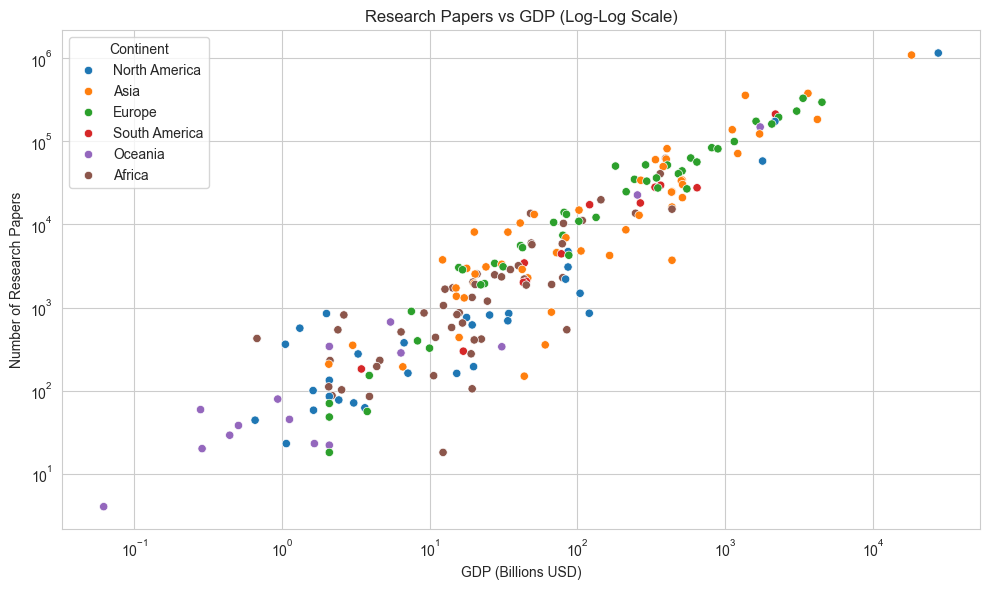

In [296]:
# Scatter plot of Paper Count vs GDP
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_api_papers_sorted, x='GDP (Billions USD)', y='paper_count', hue='continent')
plt.title('Research Papers vs GDP (Log-Log Scale)')
plt.xlabel('GDP (Billions USD)')
plt.ylabel('Number of Research Papers')
plt.legend(title='Continent')

# Set both axes to a log scale
plt.xscale('log')
plt.yscale('log')

plt.tight_layout()
plt.show()

Interactive graph (top 20 countries)

In [297]:
# Sort data so the plot is ordered
top_20_data = data_api_papers_sorted[:20].sort_values("paper_count", ascending=True)

# Create a log-transformed column for GDP
top_20_data['GDP_log'] = np.log10(top_20_data['GDP (Billions USD)'])

fig = px.bar(
    top_20_data,
    x="paper_count",
    y="Country",
    color="GDP_log",
    color_continuous_scale="Blues",
    text="paper_count",
    title="Top 20 Countries by Research Paper Count",
    template="plotly_white",
    hover_data={
        "GDP (Billions USD)": ":,.2f", 
        "GDP_log": False,
        "paper_count": False
    },
    height=700 
)

# Define the labels we want to see (real GDP values)
tick_labels = ["100B", "500B", "1,000B", "5,000B", "10,000B", "20,000B"]
# Corresponding log10 values for the ticks
tick_values = [
    np.log10(100),    
    np.log10(500),    
    np.log10(1000),   
    np.log10(5000),   
    np.log10(10000),  
    np.log10(20000)   
]

fig.update_layout(
    yaxis_title=None, 
    coloraxis_colorbar=dict(
        title="GDP (Billions USD)",
        tickvals=tick_values,
        ticktext=tick_labels
    )
)

fig.update_traces(
    texttemplate='%{x:,.0f}', 
    textposition='auto'       
)

fig.show()

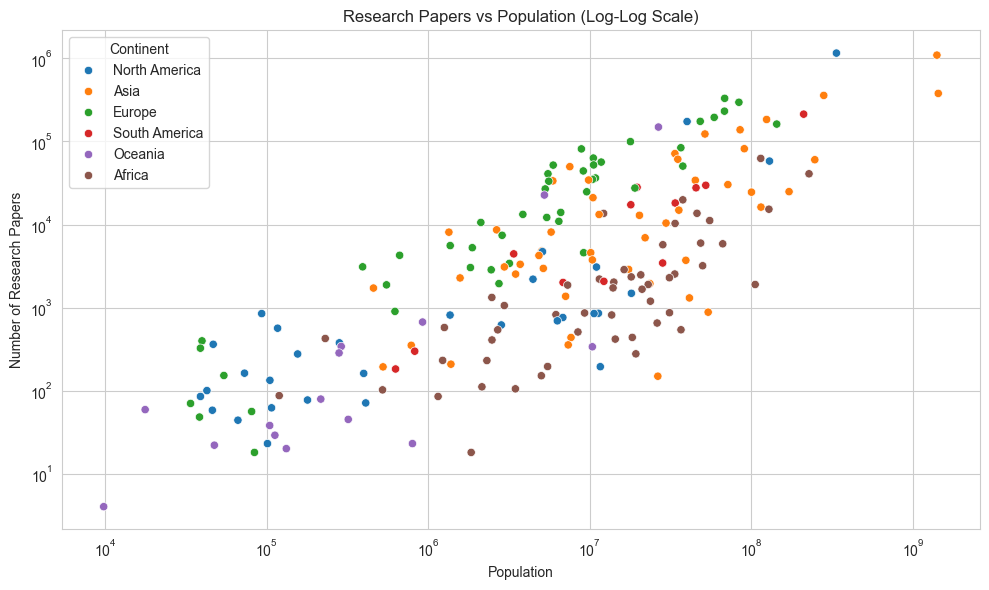

In [298]:
# Set a cleaner style
sns.set_style("whitegrid") 

plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_api_papers_sorted, x='Population', y='paper_count', hue='continent')
plt.title('Research Papers vs Population (Log-Log Scale)')
plt.xlabel('Population')
plt.ylabel('Number of Research Papers')
plt.legend(title='Continent')

# Set both axes to a log scale
plt.xscale('log')
plt.yscale('log')

plt.tight_layout()
plt.show()

In [299]:
# Sort data so the plot is ordered
top_20_data = data_api_papers_sorted[:20].sort_values("paper_count", ascending=True)

# Create a log-transformed column for Population
top_20_data['Population_log'] = np.log10(top_20_data['Population'])

fig = px.bar(
    top_20_data,
    x="paper_count",
    y="Country",
    color="Population_log",
    color_continuous_scale="Blues", 
    text="paper_count",
    title="Top 20 Countries by Research Paper Count",
    template="plotly_white",
    labels={
        "paper_count": "Number of Research Papers",
        "Population_log": "Population" 
    },
    hover_data={
        "Population": ":,.0f",
        "Population_log": False
    },
    height=700 
)

# Fix the color bar legend
tick_labels = ["10M", "50M", "100M", "500M", "1B"]
tick_values = [
    np.log10(10_000_000),    
    np.log10(50_000_000),   
    np.log10(100_000_000),  
    np.log10(500_000_000),  
    np.log10(1_000_000_000)
]

fig.update_layout(
    yaxis_title=None, 
    coloraxis_colorbar=dict(
        title="Population",
        tickvals=tick_values,  # Set the POSITIONS for the ticks
        ticktext=tick_labels   # Set the TEXT for the ticks
    )
)

fig.update_traces(
    texttemplate='%{x:,.0f}', 
    textposition='auto',
    hovertemplate='<b>%{y}</b><br>Population: %{customdata[0]}<extra></extra>'
)

fig.show()

Now let's make the normalization, we'll create a new metric using the two most correlated features to papers_count

To prevent that our metric from being skewed by countries with very small populations, we only consider countries with at least 500,000 inhabitants.

In [300]:
data_api_papers_sorted_500000 = data_api_papers_sorted[data_api_papers_sorted['Population'] >= 500000]

In [301]:
new_correlation_matrix = data_api_papers_sorted_500000.select_dtypes(include=['float', 'int']).corr()['paper_count'].sort_values(ascending=False)
new_correlation_matrix

paper_count                  1.000000
GDP (Billions USD)           0.951732
Population                   0.693494
GDP (Billions USD)_log       0.603132
Population_log               0.491663
GDP per Capita (USD)         0.270271
GDP per Capita (USD)_log     0.269247
Tertiary Enrollment (%)      0.226733
Life Expectancy (Years)      0.224680
Internet Users (%)           0.215225
Urban Population (%)         0.179617
Unemployment Rate (%)_log   -0.061215
Unemployment Rate (%)       -0.101264
Name: paper_count, dtype: float64

In [302]:
data_api_papers_sorted_500000

,Country,ISO3,Internet Users (%),GDP per Capita (USD),Tertiary Enrollment (%),Unemployment Rate (%),Life Expectancy (Years),Population,Urban Population (%),continent,GDP (Billions USD),GDP (Billions USD)_log,GDP per Capita (USD)_log,Unemployment Rate (%)_log,Population_log,ISO2,paper_count
0,United States,USA,93.14440,82304.620427,67.617928,3.638,78.385366,3.368062e+08,83.298000,North America,27720.709000,10.229971,11.318195,1.534283,19.635018,US,1159821
1,China,CHN,90.60000,12951.178240,74.593301,4.670,77.953000,1.410710e+09,64.570000,Asia,18270.356655,9.813090,9.469019,1.735189,21.067359,CN,1096429
2,India,IND,69.57645,2530.120313,34.009170,4.172,72.003000,1.438070e+09,36.364000,Asia,3638.489096,8.199599,7.836417,1.643259,21.086567,IN,379134
3,Indonesia,IDN,69.20840,4876.307745,44.881303,3.308,71.146000,2.811901e+08,58.572000,Asia,1371.169302,7.224148,8.492349,1.460474,19.454541,ID,358646
4,United Kingdom,GBR,96.29880,49200.810153,80.498772,3.984,81.238098,6.849200e+07,84.642000,Europe,3369.861889,8.122924,10.803686,1.606233,18.042228,GB,330715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,Djibouti,DJI,65.02480,3397.520158,19.035761,26.154,65.987000,1.152944e+06,78.552000,Africa,3.917150,1.592729,8.131095,3.301524,13.957830,DJ,85
197,Solomon Islands,SLB,42.45970,2076.107688,10.477030,1.455,70.528000,8.000050e+05,26.037000,Oceania,1.660897,0.978663,7.638732,0.898127,13.592375,SB,23
201,Equatorial Guinea,GNQ,60.36610,6677.793435,14.610664,8.367,63.707000,1.847549e+06,74.448000,Africa,12.337551,2.590583,8.806693,2.237193,14.429371,GQ,18
203,Comoros,COM,35.66780,1682.202851,8.886243,3.776,66.777000,8.503870e+05,30.132000,Africa,1.430523,0.888107,7.428454,1.563603,13.653448,KM,0


Papers per Billion USD

In [303]:
papers_per_billion_usd = data_api_papers_sorted_500000['paper_count'] / data_api_papers_sorted_500000['GDP (Billions USD)']
papers_per_billion_usd.describe()

count    168.000000
mean      87.965318
std       66.931797
min        0.000000
25%       42.429723
50%       78.930403
75%      115.965890
max      403.862410
dtype: float64

Papers per 1000 people

In [304]:
papers_per_1000_people = data_api_papers_sorted_500000['paper_count'] / (data_api_papers_sorted_500000['Population'] / 1000)
papers_per_1000_people.describe()

count    168.000000
mean       1.365088
std        1.921953
min        0.000000
25%        0.119305
50%        0.448949
75%        1.667254
max        9.159108
dtype: float64

The final metric will be a weighted mean (based on the correlations) of the zscores (normalized) values of our two metrics

#### research_final_metric = weight_population * z(papers_per_1000_people) + weight_gdp * z(papers_per_billions_usd)

where

##### weight_population = corr(papers, population)

##### weight_gdp = corr(papers, gdp)

In [305]:
total_corr = new_correlation_matrix['GDP (Billions USD)'] + new_correlation_matrix['Population']
weight_gdp = new_correlation_matrix['GDP (Billions USD)'] / total_corr
weight_population = new_correlation_matrix['Population'] / total_corr
data_api_papers_sorted_500000['research_final_metric'] = (weight_gdp*(zscore(papers_per_billion_usd))) + (weight_population*(zscore(papers_per_1000_people)))

C:\Users\anton\AppData\Local\Temp\ipykernel_4292\1592220914.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [306]:
data_api_papers_sorted_500000.head()

,Country,ISO3,Internet Users (%),GDP per Capita (USD),Tertiary Enrollment (%),Unemployment Rate (%),Life Expectancy (Years),Population,Urban Population (%),continent,GDP (Billions USD),GDP (Billions USD)_log,GDP per Capita (USD)_log,Unemployment Rate (%)_log,Population_log,ISO2,paper_count,research_final_metric
0,United States,USA,93.14440,82304.620427,67.617928,3.638,78.385366,3.368062e+08,83.298,North America,27720.709000,10.229971,11.318195,1.534283,19.635018,US,1159821,0.057365
1,China,CHN,90.60000,12951.178240,74.593301,4.670,77.953000,1.410710e+09,64.570,Asia,18270.356655,9.813090,9.469019,1.735189,21.067359,CN,1096429,-0.371640
2,India,IND,69.57645,2530.120313,34.009170,4.172,72.003000,1.438070e+09,36.364,Asia,3638.489096,8.199599,7.836417,1.643259,21.086567,IN,379134,-0.101548
3,Indonesia,IDN,69.20840,4876.307745,44.881303,3.308,71.146000,2.811901e+08,58.572,Asia,1371.169302,7.224148,8.492349,1.460474,19.454541,ID,358646,1.485140
4,United Kingdom,GBR,96.29880,49200.810153,80.498772,3.984,81.238098,6.849200e+07,84.642,Europe,3369.861889,8.122924,10.803686,1.606233,18.042228,GB,330715,0.850057


In [307]:
data_api_papers_sorted_500000.sort_values(by='research_final_metric', ascending=False).reset_index(drop=True)

,Country,ISO3,Internet Users (%),GDP per Capita (USD),Tertiary Enrollment (%),Unemployment Rate (%),Life Expectancy (Years),Population,Urban Population (%),continent,GDP (Billions USD),GDP (Billions USD)_log,GDP per Capita (USD)_log,Unemployment Rate (%)_log,Population_log,ISO2,paper_count,research_final_metric
0,Lebanon,LBN,83.4933,3477.724898,54.401256,11.543,77.817000,5773493.0,89.432000,Asia,20.078620,3.048259,8.154421,2.529163,15.568788,LB,8109,2.747086
1,Cyprus,CYP,91.2211,36551.417969,99.021683,6.098,81.648000,1344976.0,66.987000,Asia,33.886931,3.552112,10.506503,1.959813,14.111887,CY,8089,2.329409
2,Denmark,DNK,98.7756,68453.876928,81.230820,5.094,81.853659,5946952.0,88.495000,Europe,407.091920,6.011492,11.133930,1.807305,15.598390,DK,51927,1.963659
3,Switzerland,CHE,97.3444,100631.802755,74.006088,4.043,84.056098,8888093.0,74.202000,Europe,894.424822,6.797298,11.519234,1.618001,16.000223,CH,81407,1.740924
4,Tajikistan,TJK,56.7910,1178.479901,34.968963,11.546,71.790000,10389799.0,28.234000,Asia,12.244169,2.583557,7.072829,2.529402,16.156335,TJ,3748,1.670052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,Eritrea,ERI,38.3791,5595.138059,14.884170,5.586,68.624000,3470390.0,43.267000,Africa,19.417311,3.016383,8.629832,1.884946,15.059778,ER,105,-1.009295
164,"Korea, Dem. People's Rep.",PRK,85.9607,1655.507030,73.206001,2.831,73.642000,26418204.0,63.203000,Asia,43.735522,3.800768,7.412466,1.343126,17.089564,KP,149,-1.032053
165,Equatorial Guinea,GNQ,60.3661,6677.793435,14.610664,8.367,63.707000,1847549.0,74.448000,Africa,12.337551,2.590583,8.806693,2.237193,14.429371,GQ,18,-1.048036
166,Comoros,COM,35.6678,1682.202851,8.886243,3.776,66.777000,850387.0,30.132000,Africa,1.430523,0.888107,7.428454,1.563603,13.653448,KM,0,-1.062827


Interactive graph (Top 20 countries)

In [308]:
# Select top 20 countries by the final research metric
top_20_metric = data_api_papers_sorted_500000.sort_values(by='research_final_metric', ascending=False).head(20).copy()

# Create log scale for color
top_20_metric['paper_count_log'] = np.log10(top_20_metric['paper_count'])

# Create the combined label
top_20_metric['Country_Label'] = top_20_metric['Country'] + " (" + top_20_metric['continent'] + ")"

# Create the Bar Chart
fig = px.bar(
    top_20_metric,
    x="research_final_metric",
    y="Country_Label",
    color="paper_count_log",
    color_continuous_scale="Blues",
    title="Top 20 Countries: Efficiency vs. Volume (Color)",
    template="plotly_white",
    text="research_final_metric",
    hover_data={
        "research_final_metric": ":.2f",
        "paper_count": ":,.0f",
        "paper_count_log": False,
        "Country_Label": False,
        "continent": True 
    },
    height=800
)

# Add the Color Legend
tick_labels = ["10k", "20k", "50k", "100k", "200k", "500k", "1M", "2M"]
tick_values = [
    np.log10(10_000),
    np.log10(20_000),   
    np.log10(50_000),
    np.log10(100_000),
    np.log10(200_000), 
    np.log10(500_000),
    np.log10(1_000_000),
    np.log10(2_000_000)
]

fig.update_layout(
    yaxis=dict(autorange="reversed"), 
    xaxis_title="Research Final Metric",
    yaxis_title="Country (Continent)",
    
    coloraxis_colorbar=dict(
        title="Paper Count",
        tickvals=tick_values,
        ticktext=tick_labels
    )
)

fig.update_traces(
    texttemplate='%{x:.2f}',
    textposition='outside'
)

fig.show()

We can see that, after the normalization, some smaller or less wealthy countries demonstrate high research productivity relative to their resources, indicating efficient use of their capabilities in research output. 

Europe together have 11 countries among the top 20 in terms of research efficiency. Expecially Eastern and Northern countries make up a large share of this ranking.

Now we have information about the most efficient and active countries in term of research. 

### What about topics?

We're going to concentrate on three topics specifically (AI, Climate Science, Medicine) and we'll use the same metric to estimate which country are the most efficient in these type of papers

In OpenAlexAPI every topic has a specific code, we're going to choose the most similar to our topics

###  Topic           --> Concept Name (esempio)  --> Concept ID (OpenAlex) 


AI              --> Artificial intelligence --> `C154945302`           


 Climate Science --> Environmental Science          --> `C39432304`           


 Medicine         --> Medicine                  --> `C71924100`           


In [309]:
# We focus always on countries with population > 500,000
data_api_topics = data_api_papers_sorted_500000.copy().drop(columns=['paper_count', 'research_final_metric'])

In [310]:
# Define cache filename
CACHE_FILENAME = "topics_paper_counts.json" 

# Check if cache file exists
if os.path.exists(CACHE_FILENAME):
    print(f"Loading data from cache: {CACHE_FILENAME}")
    # Use pandas to read the JSON file back into a DataFrame
    data_api_topics = pd.read_json(CACHE_FILENAME, orient="records") 

# If there is no cache, run your original code
else:
    print("Cache not found. Running original API loops...")
    
    countries = data_api_topics["ISO2"] 
    
    topic = {
        "AI": "C154945302",      
        "Environment": "C39432304",      
        "Medicine": "C71924100"      
    }
    
    for topic_name, topic_id in topic.items():
        paper_counts = []
        for c in countries:
            params = {
                "filter": f"publication_year:2023,authorships.institutions.country_code:{c},concepts.id:{topic_id}"
            }
            r = requests.get(BASE_URL, params=params)
            
            if r.status_code == 200:
                count = r.json()["meta"]["count"]
                paper_counts.append(count)
                print(f"{c} - {topic_name}: {count}")
            else:
                print(f"Error for {c} - {topic_name}")
                paper_counts.append(None) 
            time.sleep(1)  
            
        # This works perfectly for adding a new column to the DataFrame
        data_api_topics[topic_name + "_paper_count"] = paper_counts
    
    # Save the populated DataFrame using pandas' .to_json()
    print(f"\nSaving data to {CACHE_FILENAME} for next time...")
    data_api_topics.to_json(CACHE_FILENAME, orient="records", indent=4) 
    print("Data saved.")

print("\n--- Final Data Ready for Use ---")

Loading data from cache: topics_paper_counts.json

--- Final Data Ready for Use ---


Let's observe the correlation matrix of the three new features created

In [311]:
corr_AI=data_api_topics.select_dtypes(include=['float', 'int']).corr()['AI_paper_count'].sort_values(ascending=False)
corr_env = data_api_topics.select_dtypes(include=['float', 'int']).corr()['Environment_paper_count'].sort_values(ascending=False)
corr_med = data_api_topics.select_dtypes(include=['float', 'int']).corr()['Medicine_paper_count'].sort_values(ascending=False)

display(corr_AI)
display(corr_env)
display(corr_med)

AI_paper_count               1.000000
GDP (Billions USD)           0.856627
Environment_paper_count      0.850528
Medicine_paper_count         0.841292
Population                   0.809122
GDP (Billions USD)_log       0.518861
Population_log               0.446977
Tertiary Enrollment (%)      0.206167
GDP per Capita (USD)_log     0.204869
GDP per Capita (USD)         0.188796
Life Expectancy (Years)      0.187985
Internet Users (%)           0.181332
Urban Population (%)         0.125390
Unemployment Rate (%)_log   -0.054887
Unemployment Rate (%)       -0.088188
Name: AI_paper_count, dtype: float64

Environment_paper_count      1.000000
GDP (Billions USD)           0.988632
Medicine_paper_count         0.982582
AI_paper_count               0.850528
Population                   0.584875
GDP (Billions USD)_log       0.517165
Population_log               0.415084
GDP per Capita (USD)         0.269399
GDP per Capita (USD)_log     0.237488
Tertiary Enrollment (%)      0.210897
Internet Users (%)           0.177378
Life Expectancy (Years)      0.176385
Urban Population (%)         0.147604
Unemployment Rate (%)_log   -0.056440
Unemployment Rate (%)       -0.087872
Name: Environment_paper_count, dtype: float64

Medicine_paper_count         1.000000
Environment_paper_count      0.982582
GDP (Billions USD)           0.968838
AI_paper_count               0.841292
GDP (Billions USD)_log       0.589511
Population                   0.588699
Population_log               0.460877
GDP per Capita (USD)         0.313432
GDP per Capita (USD)_log     0.284709
Tertiary Enrollment (%)      0.244398
Life Expectancy (Years)      0.228307
Internet Users (%)           0.211564
Urban Population (%)         0.188373
Unemployment Rate (%)_log   -0.060824
Unemployment Rate (%)       -0.098684
Name: Medicine_paper_count, dtype: float64

As we can see the two features with the highest correlation (obv not considering the papers_count features) are GDP and Population

AI TOPIC

In [312]:
# Calculate research metric for AI papers
papers_per_billion_usd_AI = data_api_topics['AI_paper_count'] / data_api_topics['GDP (Billions USD)']
papers_per_1000_people_AI = data_api_topics['AI_paper_count'] / (data_api_topics['Population'] / 1000)
total_corr_AI = corr_AI['GDP (Billions USD)'] + corr_AI['Population']
weight_gdp_AI = corr_AI['GDP (Billions USD)'] / total_corr_AI
weight_population_AI = corr_AI['Population'] / total_corr_AI
data_api_topics['research_metric_AI'] = (weight_gdp_AI*(zscore(papers_per_billion_usd_AI))) + (weight_population_AI*(zscore(papers_per_1000_people_AI)))

In [313]:
fig = px.scatter(
    data_api_topics.sort_values(by = 'AI_paper_count', ascending=False).reset_index(drop=True)[:20],
    x="AI_paper_count",
    y="research_metric_AI",
    color="continent",
    hover_name="Country",
    hover_data={
        "research_metric_AI": True,
        "AI_paper_count": True,
        "continent": True
    },
    title="Top 20 Countries with most AI Research Papers"
)

fig.update_layout(
    xaxis_title="Number of AI Research Papers",
    yaxis_title="AI Research Metric",
    legend_title="Continent",
    template="plotly_white"
)

fig.show()

In [314]:
fig = px.scatter(
    data_api_topics.sort_values(by='research_metric_AI', ascending=False).reset_index(drop=True)[:20],
    x="AI_paper_count",
    y="research_metric_AI",
    color="continent",
    hover_name="Country",
    hover_data={
        "research_metric_AI": True,
        "AI_paper_count": True,
        "continent": True
    },
    title="Top 20 Countries with highest AI Research Metric",
)

fig.update_layout(
    xaxis_title="Number of AI Research Papers",
    yaxis_title="AI Research Metric",
    legend_title="Continent",
    template="plotly_white"
)

fig.show()

In [315]:
print("Top 20 Countries by Number of AI Research Papers:")
display(data_api_topics[['Country', 'AI_paper_count', 'research_metric_AI']].sort_values(by='AI_paper_count', ascending=False).reset_index(drop=True)[:20])
print("Top 20 Countries by AI Research Metric:")
display(data_api_topics[['Country', 'AI_paper_count', 'research_metric_AI']].sort_values(by='research_metric_AI', ascending=False).reset_index(drop=True)[:20])

Top 20 Countries by Number of AI Research Papers:


,Country,AI_paper_count,research_metric_AI
0,China,220554,0.226199
1,United States,110214,0.070213
2,India,65903,0.376088
3,United Kingdom,37988,0.962191
4,Germany,33137,0.407216
5,Indonesia,29222,0.685187
6,Italy,21877,0.491808
7,France,21534,0.234221
8,Japan,21195,-0.174908
9,Canada,21091,0.810694


Top 20 Countries by AI Research Metric:


,Country,AI_paper_count,research_metric_AI
0,"Hong Kong SAR, China",10172,3.466873
1,Lebanon,1176,3.148842
2,Cyprus,1036,2.561336
3,Singapore,7260,2.474452
4,Tunisia,2107,2.184018
5,Jordan,2090,2.032886
6,Switzerland,8542,1.657997
7,Luxembourg,666,1.615064
8,Norway,4921,1.559963
9,Denmark,4931,1.554097


In [119]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 1. Prepare the Data
# Top 20 by Volume
top_vol = data_api_topics.sort_values(by='AI_paper_count', ascending=False).head(20)
top_vol = top_vol.sort_values(by='AI_paper_count', ascending=True)

# Top 20 by Metric
top_eff = data_api_topics.sort_values(by='research_metric_AI', ascending=False).head(20)
top_eff = top_eff.sort_values(by='research_metric_AI', ascending=True)

# 2. Identify Overlaps
overlap_countries = set(top_vol['Country']).intersection(set(top_eff['Country']))
def get_color(country):
    return '#FF00FF' if country in overlap_countries else '#1f77b4'

# 3. Create Subplots
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Top 20 by Volume (Label: Efficiency Metric)", "Top 20 by Efficiency (Label: Paper Count)"),
    horizontal_spacing=0.15
)

# --- LEFT CHART (Volume) ---
fig.add_trace(
    go.Bar(
        x=top_vol['AI_paper_count'],
        y=top_vol['Country'],
        orientation='h',
        marker_color=[get_color(c) for c in top_vol['Country']],
        
        # Label is the METRIC, positioned OUTSIDE
        text=top_vol['research_metric_AI'],
        texttemplate='%{text:.2f}', 
        textposition='outside',
        name="Volume Bar",
        hovertemplate="<b>%{y}</b><br>Volume: %{x:,.0f}<br>Metric: %{text:.2f}<extra></extra>"
    ),
    row=1, col=1
)

# --- RIGHT CHART (Efficiency) ---
fig.add_trace(
    go.Bar(
        x=top_eff['research_metric_AI'],
        y=top_eff['Country'],
        orientation='h',
        marker_color=[get_color(c) for c in top_eff['Country']],
        
        # Label is the COUNT, positioned OUTSIDE
        text=top_eff['AI_paper_count'],
        texttemplate='%{text:,.0f}',
        textposition='outside',
        name="Efficiency Bar",
        hovertemplate="<b>%{y}</b><br>Metric: %{x:.2f}<br>Volume: %{text:,.0f}<extra></extra>"
    ),
    row=1, col=2
)

# 4. Update Layout
fig.update_layout(
    title_text="Comparison: Giants (Efficiency Label) vs. Specialists (Volume Label)",
    showlegend=False,
    template="plotly_white",
    height=800,
    # Automatically expand axes to fit the outside text
    xaxis=dict(autorange=True),
    xaxis2=dict(autorange=True)
)

fig.show()

Netherlands, Hong Kong and Australia are in both rankings. It means that they publish lot of papers and also are really efficient.   
Good result for Europe and Asia

ENVIRONMENTAL TOPIC

In [316]:
# Calculate research metric for AI papers
papers_per_billion_usd_env = data_api_topics['Environment_paper_count'] / data_api_topics['GDP (Billions USD)']
papers_per_1000_people_env = data_api_topics['Environment_paper_count'] / (data_api_topics['Population'] / 1000)
total_corr_env = corr_env['GDP (Billions USD)'] + corr_env['Population']
weight_gdp_env = corr_env['GDP (Billions USD)'] / total_corr_env
weight_population_env = corr_env['Population'] / total_corr_env
data_api_topics['research_metric_env'] = (weight_gdp_env*(zscore(papers_per_billion_usd_env))) + (weight_population_env*(zscore(papers_per_1000_people_env)))

In [317]:
fig = px.scatter(
    data_api_topics.sort_values(by = 'Environment_paper_count', ascending=False).reset_index(drop=True)[:20],
    x="Environment_paper_count",
    y="research_metric_env",
    color="continent",
    hover_name="Country",
    hover_data={
        "research_metric_env": True,
        "Environment_paper_count": True,
        "continent": True
    },
    title="Top 20 Countries with most Environmental Research Papers"
)

fig.update_layout(
    xaxis_title="Number of Environmental Research Papers",
    yaxis_title="Environmental Research Metric",
    legend_title="Continent",
    template="plotly_white"
)

fig.show()

In [318]:
fig = px.scatter(
    data_api_topics.sort_values(by='research_metric_env', ascending=False).reset_index(drop=True)[:20],
    x="Environment_paper_count",
    y="research_metric_env",
    color="continent",
    hover_name="Country",
    hover_data={
        "research_metric_env": True,
        "Environment_paper_count": True,
        "continent": True
    },
    title="Top 20 Countries with highest Environmental Research Metric"
)

fig.update_layout(
    xaxis_title="Number of Environmental Research Papers",
    yaxis_title="Environmental Research Metric",
    legend_title="Continent",
    template="plotly_white"
)

fig.show()

In [319]:
print("Top 20 Countries by Number of Environmental Research Papers:")
display(data_api_topics[['Country', 'Environment_paper_count', 'research_metric_env']].sort_values(by='Environment_paper_count', ascending=False).reset_index(drop=True)[:20])
print("Top 20 Countries by AI Research Metric:")
display(data_api_topics[['Country', 'Environment_paper_count', 'research_metric_env']].sort_values(by='research_metric_env', ascending=False).reset_index(drop=True)[:20])

Top 20 Countries by Number of Environmental Research Papers:


,Country,Environment_paper_count,research_metric_env
0,United States,141664,0.549575
1,China,85340,-0.371885
2,India,28529,-0.090125
3,United Kingdom,19674,0.315037
4,Indonesia,19277,0.772482
5,Germany,19012,-0.027475
6,France,14475,0.002203
7,Spain,13999,0.656425
8,Italy,12983,0.128454
9,Canada,12191,0.328371


Top 20 Countries by AI Research Metric:


,Country,Environment_paper_count,research_metric_env
0,Cyprus,726,2.791933
1,Tajikistan,342,2.348850
2,Denmark,4640,2.170602
3,Lebanon,502,2.128119
4,Norway,4520,2.019594
5,Nepal,965,1.817905
6,Finland,3378,1.754301
7,Estonia,556,1.514884
8,Switzerland,6189,1.431538
9,Burundi,54,1.392879


Only Switzerland appears in both the lists. Nice job by Europe, expecially for Denmark (Second Place)

MEDICINE TOPIC

In [320]:
# Calculate research metric for AI papers
papers_per_billion_usd_med = data_api_topics['Medicine_paper_count'] / data_api_topics['GDP (Billions USD)']
papers_per_1000_people_med = data_api_topics['Medicine_paper_count'] / (data_api_topics['Population'] / 1000)
total_corr_med = corr_med['GDP (Billions USD)'] + corr_med['Population']
weight_gdp_med = corr_med['GDP (Billions USD)'] / total_corr_med
weight_population_med = corr_med['Population'] / total_corr_med
data_api_topics['research_metric_med'] = (weight_gdp_med*(zscore(papers_per_billion_usd_med))) + (weight_population_med*(zscore(papers_per_1000_people_med)))

In [321]:
fig = px.scatter(
    data_api_topics.sort_values(by = 'Medicine_paper_count', ascending=False).reset_index(drop=True)[:20],
    x="Medicine_paper_count",
    y="research_metric_med",
    color="continent",
    hover_name="Country",
    hover_data={
        "research_metric_med": True,
        "Medicine_paper_count": True,
        "continent": True
    },
    title="Top 20 Countries with most Medical Research Papers"
)

fig.update_layout(
    xaxis_title="Number of Medical Research Papers",
    yaxis_title="Medical Research Metric",
    legend_title="Continent",
    template="plotly_white"
)

fig.show()

In [322]:
fig = px.scatter(
    data_api_topics.sort_values(by='research_metric_med', ascending=False).reset_index(drop=True)[:20],
    x="Medicine_paper_count",
    y="research_metric_med",
    color="continent",
    hover_name="Country",
    hover_data={
        "research_metric_med": True,
        "Medicine_paper_count": True,
        "continent": True
    },
    title="Top 20 Countries with highest Medical Research Metric"
)

fig.update_layout(
    xaxis_title="Number of Medical Research Papers",
    yaxis_title="Medical Research Metric",
    legend_title="Continent",
    template="plotly_white"
)

fig.show()

In [323]:
print("Top 20 Countries by Number of Medical Research Papers:")
display(data_api_topics[['Country', 'Medicine_paper_count', 'research_metric_med']].sort_values(by='Medicine_paper_count', ascending=False).reset_index(drop=True)[:20])
print("Top 20 Countries by Medical Research Metric:")
display(data_api_topics[['Country', 'Medicine_paper_count', 'research_metric_med']].sort_values(by='research_metric_med', ascending=False).reset_index(drop=True)[:20])

Top 20 Countries by Number of Medical Research Papers:


,Country,Medicine_paper_count,research_metric_med
0,United States,480001,0.193414
1,China,272314,-0.547484
2,United Kingdom,130780,0.977632
3,India,129640,-0.107181
4,Germany,89683,0.055930
5,Italy,78585,0.544571
6,Indonesia,74881,0.445945
7,Japan,73939,-0.261843
8,Canada,69262,0.710497
9,Brazil,66437,-0.110126


Top 20 Countries by Medical Research Metric:


,Country,Medicine_paper_count,research_metric_med
0,Lebanon,3449,3.441003
1,"Gambia, The",373,2.799996
2,Cyprus,2761,2.081015
3,Nepal,5123,2.078385
4,Denmark,19383,1.937246
5,Tunisia,5342,1.890307
6,Switzerland,31166,1.767869
7,Jordan,5139,1.650700
8,Portugal,17664,1.376715
9,Sweden,24621,1.292330


5 Countries are in both rankings, so we should concentrate on that. There are also new very entries in original ranking like Egypt, Russia, Korea and Italy and also some new countries in our metric ranking like Malawi, Gambia, Gaza and Uganda

### PCA and UMAP

In [324]:
dev_indicators = [
    'Internet Users (%)',
    'GDP per Capita (USD)_log',
    'Tertiary Enrollment (%)',
    'Unemployment Rate (%)_log',
    'Life Expectancy (Years)',
    'Population_log',
    'Urban Population (%)'
]

dev_data = data_api_topics[dev_indicators].copy()

#scale the data (PCA is sensitive to different scales)
scaler = StandardScaler()
dev_data_scaled = scaler.fit_transform(dev_data)

In [325]:
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(dev_data_scaled)
data_api_topics['UMAP_1'] = embedding[:, 0]
data_api_topics['UMAP_2'] = embedding[:, 1]


fig_umap = px.scatter(
    data_api_topics,
    x="UMAP_1",
    y="UMAP_2",
    color="continent",
    hover_name="Country",
    title="Country Clusters by Development (UMAP)"
)

fig_umap.update_layout(
    xaxis_title="UMAP Component 1",
    yaxis_title="UMAP Component 2",
    legend_title="Continent",
    template="plotly_white"
)
fig_umap.update_traces(marker=dict(size=8))
fig_umap.show()

c:\Users\anton\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



This plot visualizes the result of our dimensionality reduction.

We fed our 7 development indicators (GDP, Life Expectancy, Internet Users %, etc.) into the UMAP algorithm.

UMAP's job is to create a 2D "map" where the distance between countries represents how similar they are across all 7 of those indicators.

We can clearly see the countries have clustered by continent. The green "Europe" dots are all grouped together and are far away from the blue "Africa" dots for example. This confirms that our 7 indicators are a good way to measure development.


In [326]:
#PCA
pca = PCA(n_components=1) 
development_index_pc1 = pca.fit_transform(dev_data_scaled)

#add this new index back to the main dataframe
data_api_topics['Development_Index'] = development_index_pc1

print("\how much each indicator contributes:")
loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC1'], 
                        index=dev_indicators)
print(loadings.sort_values('PC1', ascending=False))

\how much each indicator contributes:
                                PC1
GDP per Capita (USD)_log   0.466529
Internet Users (%)         0.460736
Life Expectancy (Years)    0.460631
Tertiary Enrollment (%)    0.425560
Urban Population (%)       0.414418
Unemployment Rate (%)_log  0.009530
Population_log            -0.070412


<>:8: SyntaxWarning:

invalid escape sequence '\h'

<>:8: SyntaxWarning:

invalid escape sequence '\h'

C:\Users\anton\AppData\Local\Temp\ipykernel_4292\2669789872.py:8: SyntaxWarning:

invalid escape sequence '\h'



In [327]:
# Calculate the mean (as requested)
mean_ai = data_api_topics['research_metric_AI'].mean()

# Create a sqrt-transformed column for size
data_api_topics['AI_paper_count_sqrt'] = np.sqrt(data_api_topics['AI_paper_count'])

fig_ai = px.scatter(
    data_api_topics,
    x="Development_Index",
    y="research_metric_AI",
    hover_name="Country",
    size="AI_paper_count_sqrt",  
    size_max=30,                  
    color="continent",
    hover_data={
        "AI_paper_count": True,       
        "AI_paper_count_sqrt": False  
    },
    title="Development Index vs. AI Research Efficiency (Sqrt Size)",
    labels={
        'Development_Index': 'Composite Development Index (from PCA)',
        'research_metric_AI': 'AI Research Efficiency Metric',
        'AI_paper_count_sqrt': 'Paper Count (Sqrt)'
    },
    template="plotly_white"
)

fig_ai.add_hline(
    y=mean_ai,
    line_dash="dash",
    line_color="red",
    annotation_text="Mean AI Efficiency",
    annotation_position="bottom right"
)

fig_ai.show()

In [328]:
# Environment Figure

# Calculate the mean
mean_env = data_api_topics['research_metric_env'].mean()

# Create a sqrt-transformed column for size
data_api_topics['Env_paper_count_sqrt'] = np.sqrt(data_api_topics['Environment_paper_count'])

fig_env = px.scatter(
    data_api_topics,
    x="Development_Index",
    y="research_metric_env",
    hover_name="Country",
    size="Env_paper_count_sqrt",  
    size_max=30,                  
    color="continent",
    hover_data={
        "Environment_paper_count": True,  
        "Env_paper_count_sqrt": False 
    },
    title="Development Index vs. Environment Research Efficiency (Sqrt Size)",
    labels={
        'Development_Index': 'Composite Development Index (from PCA)',
        'research_metric_env': 'Environment Research Efficiency Metric',
        'Env_paper_count_sqrt': 'Paper Count (Sqrt)' 
    },
    template="plotly_white"
)

# Add horizontal line for the mean
fig_env.add_hline(
    y=mean_env,
    line_dash="dash",
    line_color="red",
    annotation_text="Mean Env. Efficiency",
    annotation_position="bottom right"
)

fig_env.show()

In [329]:
# --- 3. Medicine Figure ---

# Calculate the mean (as requested)
mean_med = data_api_topics['research_metric_med'].mean()

# Create a sqrt-transformed column for size
data_api_topics['Med_paper_count_sqrt'] = np.sqrt(data_api_topics['Medicine_paper_count'])

fig_med = px.scatter(
    data_api_topics,
    x="Development_Index",
    y="research_metric_med",
    hover_name="Country",
    size="Med_paper_count_sqrt",   # <-- Changed
    size_max=30,                  # <-- Adjusted for the new scale
    color="continent",
    hover_data={
        "Medicine_paper_count": True, # Show original count
        "Med_paper_count_sqrt": False # <-- Hide sqrt value
    },
    title="Development Index vs. Medicine Research Efficiency (Sqrt Size)", # <-- Changed
    labels={
        'Development_Index': 'Composite Development Index (from PCA)',
        'research_metric_med': 'Medicine Research Efficiency Metric',
        'Med_paper_count_sqrt': 'Paper Count (Sqrt)' # <-- Added
    },
    template="plotly_white"
)

# --- Add the horizontal mean line (as requested) ---
fig_med.add_hline(
    y=mean_med,
    line_dash="dash",
    line_color="red",
    annotation_text="Mean Med. Efficiency",
    annotation_position="bottom right"
)

fig_med.show()

NEED TEXT FOR THESE GRAPHS!

Which type of world map?

### World Map

In [330]:
N = 20

top_ai_countries = set(
    data_api_topics.sort_values(by='research_metric_AI', ascending=False)
    .head(N)['Country']
)
top_env_countries = set(
    data_api_topics.sort_values(by='research_metric_env', ascending=False)
    .head(N)['Country']
)
top_med_countries = set(
    data_api_topics.sort_values(by='research_metric_med', ascending=False)
    .head(N)['Country']
)


In [331]:
def find_top_20_profile(row):
    country = row['Country']
    
    if pd.isna(row['research_metric_AI']) and \
       pd.isna(row['research_metric_env']) and \
       pd.isna(row['research_metric_med']):
        return "Not in analysis"

    # Now, check if the country is in our Top 20 lists
    is_top_ai = country in top_ai_countries
    is_top_env = country in top_env_countries
    is_top_med = country in top_med_countries
    
    if is_top_ai and is_top_env and is_top_med:
        return "All-Round Powerhouse"
    elif is_top_ai and is_top_env:
        return "AI / Env Specialist"
    elif is_top_ai and is_top_med:
        return "AI / Med Specialist"
    elif is_top_env and is_top_med:
        return "Env / Med Specialist"
    elif is_top_ai:
        return "AI Specialist"
    elif is_top_env:
        return "Environment Specialist"
    elif is_top_med:
        return "Medicine Specialist"
    else:
        return "Not in Top 20"

data_api_topics['Top_20_Profile'] = data_api_topics.apply(find_top_20_profile, axis=1)

In [332]:
fig_map_final = px.choropleth(
    data_api_topics,
    locations="ISO3",
    color="Top_20_Profile",
    hover_name="Country",
    hover_data={'ISO3': False, 'Top_20_Profile': True},
    title="World Map of Research Profiles",
    
    color_discrete_map={
        'All-Round Powerhouse': '#FF00FF',     # Magenta
        'AI Specialist': '#1f77b4',          # Blue
        'Environment Specialist': "#2cc22c",    # Green
        'Medicine Specialist': '#d62728',      # Red
        'AI / Env Specialist': '#9467bd',        # Purple
        'AI / Med Specialist': '#e377c2',        # Pink
        'Env / Med Specialist': "#dddd20",       # yellow
        'Not in Top 20': "#FFFFFF"    # Blank/White-ish
    },
    
    category_orders={"Top_20_Profile": [
        "All-Round Powerhouse",
        "AI Specialist",
        "Environment Specialist",
        "Medicine Specialist",
        "AI / Env Specialist",
        "AI / Med Specialist",
        "Env / Med Specialist",
        "Not in Top 20",
        "Not in analysis"
    ]}
)

fig_map_final.update_layout(
    geo=dict(
        showframe=False, 
        showcoastlines=True,
        projection_type='equirectangular'
    ),
    legend_title_text='Top 20 Profile'
)

fig_map_final.show()

### Final Remarks

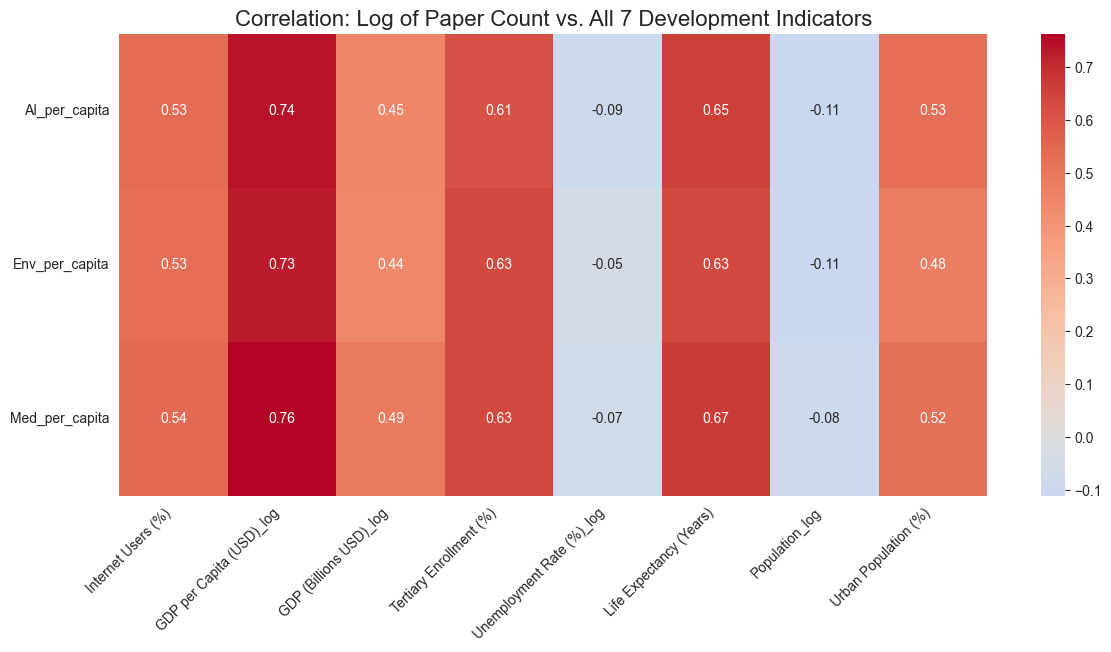

In [333]:
import matplotlib.pyplot as plt
import seaborn as sns

# (Your code for all_columns and filtered_corr goes here)

plt.figure(figsize=(14, 6))

sns.heatmap(
    filtered_corr, 
    annot=True,        # Show the correlation numbers on the map
    cmap='coolwarm',   # <-- Changed to a colorblind-friendly divergent map
    fmt=".2f",
    center=0           # <-- Add this to anchor the neutral color at 0
)

plt.title("Correlation: Log of Paper Count vs. All 7 Development Indicators", fontsize=16)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
plt.yticks(rotation=0)
plt.show()

### Conclusion: Correlation Heatmap Analysis (Per Capita)

This heatmap provides an interesting insight into our core research question: "Does a specific research area correlate more strongly with a specific development indicator when adjusted for population?"

To find this, we correlated our normalized research intensity (papers per capita) with 8 of our cleaned development indicators.

While **Economic Wealth (`GDP per Capita`)** is, as expected, the strongest overall predictor across all fields (correlations ~0.73–0.76), the **secondary drivers** reveal distinct patterns for each research domain.

* **For Medicine & AI, Health is Key:**
    * After wealth, the strongest predictor for both **Medicine** and **AI** research is **`Life Expectancy (Years)`** (0.67 for Medicine, 0.65 for AI).
    * This suggests that a society's overall health outcomes are a critical indicator of its capacity to perform advanced research in these high-tech and biological fields.

* **For Environment, Education takes the Lead:**
    * Interestingly, for **Environment** research, **`Tertiary Enrollment (%)`** (0.63) matches or slightly edges out Life Expectancy as the second most important factor.
    * This suggests that environmental research intensity may be more uniquely driven by the sheer availability of university-level talent and education infrastructure.

* **The "Small Country" Advantage:**
    * The correlation with **`Population_log`** is consistently **negative** across all fields (-0.08 to -0.11).
    * This confirms that massive scale is not an advantage for efficiency. Smaller nations are often more effective at achieving high per-capita research output than global giants.

#### Important Limitations

It is critical to state the limitations of this analysis.

**Correlation is Not Causation:** These numbers only show an *association*. We cannot conclude that `Life Expectancy` *causes* more AI research. This analysis is descriptive, not explanatory. These variables are likely all related to a country's overall development ecosystem in a complex, bidirectional way.

**Limited Features:** We are only looking at **8 specific indicators**. Other factors we did not study (such as national research funding, specific educational policies, or levels of international collaboration) could be far more important.

Therefore, these findings don't provide a "final answer" but rather point to interesting associations within our specific dataset.